# This file uses price and company factors data. Since the sentiment data starts from 2020, including it in our features would greatly decrease the amount of training samples. So the sentiment data is not taken into consideration in this file.
## Best model contained.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import random

random.seed(42)

# Get Data and Preprocess for the model

In [ ]:
Xy_train = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_2000nosenti.csv')
Xy_val = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val_2000nosenti.csv')
LOOKBACK = 60

In [ ]:
Xy_train.isna().sum().sum()

0

In [ ]:
Xy_val.isna().sum().sum()

0

In [ ]:
Xy_train.head()

date_x      Open      High       Low     Close  Adj Close     Volume  \
0  2000-02-29  3.300000  3.448438  3.293750  3.443750   3.443750  142970000   
1  2000-03-01  3.381250  3.425000  3.250000  3.293750   3.293750  111534000   
2  2000-03-02  3.246875  3.250000  3.109375  3.128125   3.128125  159602000   
3  2000-03-03  3.162500  3.237500  3.103125  3.125000   3.125000  121190000   
4  2000-03-06  3.143750  3.362500  3.140625  3.196875   3.196875  153316000   

         security    month  TRAIL_12M_NET_SALES  ...  \
0  AMZN US Equity  2000-02              1639.84  ...   
1  AMZN US Equity  2000-03              1920.08  ...   
2  AMZN US Equity  2000-03              1920.08  ...   
3  AMZN US Equity  2000-03              1920.08  ...   
4  AMZN US Equity  2000-03              1920.08  ...   

   lag1_MONTHLY_RETURN_F1_log  lag1_ma5_MONTHLY_RETURN_F1  \
0                   -3.045875                    0.015022   
1                   -3.045875                    0.015022   
2                   -3.045875                    0.015022   
3                   -3.045875                    0.015022   
4                   -3.045875                    0.015022   

   lag1_ma10_MONTHLY_RETURN_F1  lag1_ma15_MONTHLY_RETURN_F1  \
0                     0.015208                     0.015524   
1                     0.015208                     0.015524   
2                     0.015208                     0.015524   
3                     0.015208                     0.015524   
4                     0.015208                     0.015524   

   lag1_RSI_MONTHLY_RETURN_F1  lag1_MACD_MONTHLY_RETURN_F1  \
0                    49.76984                    -0.001494   
1                    49.76984                    -0.001494   
2                    49.76984                    -0.001494   
3                    49.76984                    -0.001494   
4                    49.76984                    -0.001494   

   lag1_MACD_signal_MONTHLY_RETURN_F1      date_y  MONTHLY_RETURN  \
0                           -0.000763  2000-02-29        0.066787   
1                           -0.000763  2000-03-31       -0.027223   
2                           -0.000763  2000-03-31       -0.027223   
3                           -0.000763  2000-03-31       -0.027223   
4                           -0.000763  2000-03-31       -0.027223   

   MONTHLY_RETURN_F1  
0          -0.027223  
1          -0.176299  
2          -0.176299  
3          -0.176299  
4          -0.176299  

[5 rows x 93 columns]

In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y' and col != 'MONTHLY_RETURN' and col !=  'MONTHLY_RETURN_F1':
    FINAL_FEATURES.append(col)

In [ ]:
FINAL_FEATURES

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'TRAIL_12M_NET_SALES',
 'TRAIL_12M_EPS',
 'TRAIL_12M_OPER_MARGIN',
 'EV_TO_T12M_EBITDA',
 'ENTERPRISE_VALUE',
 'BEST_PE_RATIO',
 'PX_LAST',
 'BEST_SALES',
 'BEST_EPS',
 'BEST_CUR_EV_TO_EBITDA',
 'TRAIL_12M_EBITDA',
 'CUR_MKT_CAP',
 'VOLUME',
 'TRAIL_12M_GROSS_MARGIN',
 'EBIT_MARGIN',
 'BEST_LTG_EPS',
 'IS_DIV_PER_SHR',
 'EBITDA_MARGIN',
 'TOT_DEBT_TO_TOT_ASSET',
 'SALES_GROWTH',
 'EPS_GROWTH',
 'SALES_TO_CASH',
 'CURRENT_EV_TO_T12M_EBITDA',
 'PE_RATIO',
 'EQY_SH_OUT',
 'SHORT_INT',
 'SI_PERCENT_EQUITY_FLOAT',
 'RSK_BB_IMPLIED_CDS_SPREAD',
 'IVOL_DELTA',
 'OPEN_INT_TOTAL_CALL',
 'OPEN_INT_TOTAL_PUT',
 'PX_TO_BOOK_RATIO',
 'TOT_DEBT_TO_TOT_EQY',
 'TOT_DEBT_TO_EBITDA',
 'RETURN_COM_EQY',
 'TANG_BOOK_VAL_PER_SH',
 'NET_DEBT',
 'BEST_EBITDA',
 'TRAIL_12M_OPER_INC',
 'TRAIL_12M_CAP_EXPEND',
 'FREE_CASH_FLOW_YIELD',
 'TRAIL_12M_FREE_CASH_FLOW_PER_SH',
 'daily_return',
 'price_diff',
 'roc_vol',
 'ma5_close',
 'close_vs_ema5',
 'vol

In [ ]:
def get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  securities = list(Xy_train.security.unique())
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        #X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        X_train.append(train_stock_scaled[i - LOOKBACK:i, :-1])
        #y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train
        y_train.append(train_stock_scaled[i, -1])

    #X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        #X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        X_val.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        #y_val_stock.append(val_stock_scaled[i, -1])
        y_val.append(val_stock_scaled[i, -1])

    #X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    #print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  X_train, y_train = np.array(X_train),np.array(y_train)
  X_val, y_val = np.array(X_val),np.array(y_val)
  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train
  stocks['y_train'] = y_train
  stocks['X_val'] = X_val
  stocks['y_val'] = y_val
  print(f'X_train shape :{X_train.shape}, y_train shape:{y_train.shape}; X_val shape :{X_val.shape}, y_val shape:{y_val.shape}')
  return stocks



In [ ]:
def get_data(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

    X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val_stock.append(val_stock_scaled[i, -1])

    X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stocks25[security] = stock_og

  return stocks25


def get_ONE_datav2(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  returns one dataset for all stocks, the security infomation is lost.
  stocks = {'X_train':data, 'X_val':data .. }
   Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")

  # train
  train_stock = Xy_train[f].values # take sure columns are int he right order
  scalar_stock_train = StandardScaler()
  train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

  # validation
  val_stock = Xy_val[f].values
  scalar_stock_val = StandardScaler()
  val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

  X_train_stock = []
  y_train_stock = []
  X_val_stock = []
  y_val_stock = []

  # train
  for i in range(LOOKBACK, len(train_stock_scaled)):
      X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
      y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

  X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

  # validation
  for i in range(LOOKBACK, len(val_stock_scaled)):
      X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
      y_val_stock.append(val_stock_scaled[i, -1])

  X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train_stock
  stocks['y_train'] = y_train_stock
  stocks['X_val'] = X_val_stock
  stocks['y_val'] = y_val_stock
  print(f'X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  return stocks


In [ ]:
stock25_cur = get_data(Xy_train, Xy_val, LOOKBACK, 'current', FINAL_FEATURES)
stock25_next = get_data(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,)
APTV US Equity: X_train shape :(2267, 60, 87), y_train shape:(2267,); X_val shape :(548, 60, 87), y_val shape:(548,)
AZO US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,)
BKNG US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,)
CCL US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,)
CMG US Equity: X_train shape :(3446, 60, 87), y_train shape:(3446,); X_val shape :(841, 60, 87), y_val shape:(841,)
DG US Equity: X_train shape :(2688, 60, 87), y_train shape:(2688,); X_val shape :(631, 60, 87), y_val shape:(631,)
EBAY US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,)
F US Equity: X_train shape :(4661, 60, 87), y_

In [ ]:
stock_ONE_curv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(104981, 60, 87), y_train shape:(104981,); X_val shape :(25463, 60, 87), y_val shape:(25463,)
TASK:next
X_train shape :(104981, 60, 87), y_train shape:(104981,); X_val shape :(25463, 60, 87), y_val shape:(25463,)


# Modeling

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [ ]:
def train_aggregate_model(train_df = None, val_df = None, task = None, N_epoch = 30):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  #assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, 0.01)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model2000.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
def run_model(data, task, N_epoch = 30):
  """
  train model stock by stock, so 25 models for the specified task and evaluate on that specific stock data.
  data: {'securityname': {'X_train':data, 'y_train':data.....}}
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  for key,val in data.items(): # key is the stock name
    for k,v in val.items(): # k is the dataset name: X_train, y_val .etc
      if k == 'X_train':
        single_day_feature_dim = v.shape[2]
        break
  #assert single_day_feature_dim == 90

  pred25 = {}
  for key,val in data.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_train = val['X_train']
    stock_y_train = val['y_train']
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # train model
    stock_model = create_model(single_day_feature_dim,0.01)
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath=f'weights_task_{task}_{key}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    stock_history = stock_model.fit(stock_X_train, stock_y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
    SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_{key}_model2000.h5'
    stock_model.save(SAVE_PATH)
    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25



In [ ]:
def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    for stock_name, predictions in pred25_cur.items():
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_comp.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




## Task : predict 'MONTHLY_RETURN'

### Separate model each stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'sep'

pred25_cur = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.9119
Epoch 1: val_loss improved from inf to 0.80130, saving model to weights_task_current_AMZN US Equity_model.h5
117/117 [==============================] - 15s 27ms/step - loss: 0.9119 - val_loss: 0.8013 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.3398
Epoch 2: val_loss did not improve from 0.80130
117/117 [==============================] - 2s 14ms/step - loss: 0.3408 - val_loss: 2.1612 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 0.2845
Epoch 3: val_loss did not improve from 0.80130
117/117 [==============================] - 2s 14ms/step - loss: 0.2845 - val_loss: 2.7349 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.2192
Epoch 4: val_loss did not improve from 0.80130
117/117 [==============================] - 2s 14ms/step - loss: 0.2180 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
56/57 [============================>.] - ETA: 0s - loss: 0.5969
Epoch 1: val_loss improved from inf to 1.97913, saving model to weights_task_current_APTV US Equity_model.h5
57/57 [==============================] - 8s 36ms/step - loss: 0.5947 - val_loss: 1.9791 - lr: 0.0100
Epoch 2/30
56/57 [============================>.] - ETA: 0s - loss: 0.3189
Epoch 2: val_loss improved from 1.97913 to 0.80230, saving model to weights_task_current_APTV US Equity_model.h5
57/57 [==============================] - 1s 14ms/step - loss: 0.3161 - val_loss: 0.8023 - lr: 0.0100
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.1876
Epoch 3: val_loss improved from 0.80230 to 0.78288, saving model to weights_task_current_APTV US Equity_model.h5
57/57 [==============================] - 1s 14ms/step - loss: 0.1876 - val_loss: 0.7829 - lr: 0.0100
Epoch 4/30
54/57 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1s 5ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.47041, saving model to weights_task_current_AZO US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.6903 - val_loss: 0.4704 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.2827
Epoch 2: val_loss improved from 0.47041 to 0.32619, saving model to weights_task_current_AZO US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2827 - val_loss: 0.3262 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.2068
Epoch 3: val_loss improved from 0.32619 to 0.22341, saving model to weights_task_current_AZO US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2135 - val_loss: 0.2234 - lr: 0.0100
Epoch 4/30
115/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.0930
Epoch 1: val_loss improved from inf to 0.09152, saving model to weights_task_current_BKNG US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0821 - val_loss: 0.0915 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.4664
Epoch 2: val_loss improved from 0.09152 to 0.06536, saving model to weights_task_current_BKNG US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.4681 - val_loss: 0.0654 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.3062
Epoch 3: val_loss did not improve from 0.06536
117/117 [==============================] - 2s 14ms/step - loss: 0.3050 - val_loss: 0.0801 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 0.2981
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 0.7332
Epoch 1: val_loss improved from inf to 0.36934, saving model to weights_task_current_CCL US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.7255 - val_loss: 0.3693 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.3479
Epoch 2: val_loss improved from 0.36934 to 0.36249, saving model to weights_task_current_CCL US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.3479 - val_loss: 0.3625 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 0.2583
Epoch 3: val_loss did not improve from 0.36249
117/117 [==============================] - 2s 14ms/step - loss: 0.2583 - val_loss: 0.5174 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.2252
Epoch 4:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
85/87 [============================>.] - ETA: 0s - loss: 0.7262
Epoch 1: val_loss improved from inf to 0.60963, saving model to weights_task_current_CMG US Equity_model.h5
87/87 [==============================] - 8s 29ms/step - loss: 0.7208 - val_loss: 0.6096 - lr: 0.0100
Epoch 2/30
84/87 [===========================>..] - ETA: 0s - loss: 0.2922
Epoch 2: val_loss improved from 0.60963 to 0.41834, saving model to weights_task_current_CMG US Equity_model.h5
87/87 [==============================] - 1s 14ms/step - loss: 0.2885 - val_loss: 0.4183 - lr: 0.0100
Epoch 3/30
84/87 [===========================>..] - ETA: 0s - loss: 0.2124
Epoch 3: val_loss improved from 0.41834 to 0.35199, saving model to weights_task_current_CMG US Equity_model.h5
87/87 [==============================] - 1s 14ms/step - loss: 0.2128 - val_loss: 0.3520 - lr: 0.0100
Epoch 4/30
85/87 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 5ms/step


-------------------DG US Equity--------------------
Epoch 1/30
66/68 [============================>.] - ETA: 0s - loss: 1.0147
Epoch 1: val_loss improved from inf to 0.53615, saving model to weights_task_current_DG US Equity_model.h5
68/68 [==============================] - 9s 32ms/step - loss: 1.0141 - val_loss: 0.5361 - lr: 0.0100
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 0.4668
Epoch 2: val_loss did not improve from 0.53615
68/68 [==============================] - 1s 14ms/step - loss: 0.4659 - val_loss: 0.5894 - lr: 0.0100
Epoch 3/30
64/68 [===========================>..] - ETA: 0s - loss: 0.2920
Epoch 3: val_loss improved from 0.53615 to 0.40865, saving model to weights_task_current_DG US Equity_model.h5
68/68 [==============================] - 1s 14ms/step - loss: 0.2849 - val_loss: 0.4086 - lr: 0.0100
Epoch 4/30
65/68 [===========================>..] - ETA: 0s - loss: 0.2340
Epoch 4: val_loss improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 5ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.9564
Epoch 1: val_loss improved from inf to 0.60064, saving model to weights_task_current_EBAY US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.9564 - val_loss: 0.6006 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.3739
Epoch 2: val_loss improved from 0.60064 to 0.57564, saving model to weights_task_current_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.3710 - val_loss: 0.5756 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.2785
Epoch 3: val_loss improved from 0.57564 to 0.39318, saving model to weights_task_current_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2813 - val_loss: 0.3932 - lr: 0.0100
Epoch 4/30
114/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------F US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.1365
Epoch 1: val_loss improved from inf to 0.11320, saving model to weights_task_current_F US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1194 - val_loss: 0.1132 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.6940
Epoch 2: val_loss improved from 0.11320 to 0.09614, saving model to weights_task_current_F US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.6940 - val_loss: 0.0961 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 0.5546
Epoch 3: val_loss improved from 0.09614 to 0.07171, saving model to weights_task_current_F US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.5494 - val_loss: 0.0717 - lr: 0.0100
Epoch 4/30
114/117 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------GM US Equity--------------------
Epoch 1/30
62/62 [==============================] - ETA: 0s - loss: 0.6131
Epoch 1: val_loss improved from inf to 1.30490, saving model to weights_task_current_GM US Equity_model.h5
62/62 [==============================] - 8s 34ms/step - loss: 0.6131 - val_loss: 1.3049 - lr: 0.0100
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.2676
Epoch 2: val_loss improved from 1.30490 to 1.15469, saving model to weights_task_current_GM US Equity_model.h5
62/62 [==============================] - 1s 14ms/step - loss: 0.2676 - val_loss: 1.1547 - lr: 0.0100
Epoch 3/30
60/62 [============================>.] - ETA: 0s - loss: 0.1943
Epoch 3: val_loss improved from 1.15469 to 0.89250, saving model to weights_task_current_GM US Equity_model.h5
62/62 [==============================] - 1s 15ms/step - loss: 0.1911 - val_loss: 0.8925 - lr: 0.0100
Epoch 4/30
60/62 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 1s 5ms/step


-------------------HD US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 0.6960
Epoch 1: val_loss improved from inf to 0.51372, saving model to weights_task_current_HD US Equity_model.h5
117/117 [==============================] - 10s 33ms/step - loss: 0.6959 - val_loss: 0.5137 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.2965
Epoch 2: val_loss did not improve from 0.51372
117/117 [==============================] - 2s 14ms/step - loss: 0.2965 - val_loss: 0.5715 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.2103
Epoch 3: val_loss did not improve from 0.51372
117/117 [==============================] - 2s 14ms/step - loss: 0.2101 - val_loss: 0.6871 - lr: 0.0100
Epoch 4/30
117/117 [==============================] - ETA: 0s - loss: 0.1908
Epoch 4: val_loss did not improve from 0.51372
117/117 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
43/47 [==========================>...] - ETA: 0s - loss: 0.6542
Epoch 1: val_loss improved from inf to 2.63122, saving model to weights_task_current_HLT US Equity_model.h5
47/47 [==============================] - 8s 41ms/step - loss: 0.6294 - val_loss: 2.6312 - lr: 0.0100
Epoch 2/30
44/47 [===========================>..] - ETA: 0s - loss: 0.2821
Epoch 2: val_loss improved from 2.63122 to 2.59523, saving model to weights_task_current_HLT US Equity_model.h5
47/47 [==============================] - 1s 14ms/step - loss: 0.2805 - val_loss: 2.5952 - lr: 0.0100
Epoch 3/30
44/47 [===========================>..] - ETA: 0s - loss: 0.2084
Epoch 3: val_loss did not improve from 2.59523
47/47 [==============================] - 1s 15ms/step - loss: 0.2038 - val_loss: 4.2025 - lr: 0.0100
Epoch 4/30
45/47 [===========================>..] - ETA: 0s - loss: 0.1665
Epoch 4: val_loss did 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 6ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 0.8628
Epoch 1: val_loss improved from inf to 0.75393, saving model to weights_task_current_LOW US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.8604 - val_loss: 0.7539 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.2698
Epoch 2: val_loss improved from 0.75393 to 0.74052, saving model to weights_task_current_LOW US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.2688 - val_loss: 0.7405 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.2168
Epoch 3: val_loss did not improve from 0.74052
117/117 [==============================] - 2s 15ms/step - loss: 0.2152 - val_loss: 0.7573 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.2081
Epoch 4:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
90/92 [============================>.] - ETA: 0s - loss: 0.9505
Epoch 1: val_loss improved from inf to 0.05651, saving model to weights_task_current_LVS US Equity_model.h5
92/92 [==============================] - 9s 29ms/step - loss: 0.9359 - val_loss: 0.0565 - lr: 0.0100
Epoch 2/30
89/92 [============================>.] - ETA: 0s - loss: 0.5761
Epoch 2: val_loss improved from 0.05651 to 0.02922, saving model to weights_task_current_LVS US Equity_model.h5
92/92 [==============================] - 1s 14ms/step - loss: 0.5657 - val_loss: 0.0292 - lr: 0.0100
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.3587
Epoch 3: val_loss did not improve from 0.02922
92/92 [==============================] - 1s 14ms/step - loss: 0.3587 - val_loss: 0.0539 - lr: 0.0100
Epoch 4/30
90/92 [============================>.] - ETA: 0s - loss: 0.2956
Epoch 4: val_loss did 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 5ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.6803
Epoch 1: val_loss improved from inf to 0.84702, saving model to weights_task_current_MAR US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.6803 - val_loss: 0.8470 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.2939
Epoch 2: val_loss improved from 0.84702 to 0.56323, saving model to weights_task_current_MAR US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.2926 - val_loss: 0.5632 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 0.2431
Epoch 3: val_loss improved from 0.56323 to 0.46866, saving model to weights_task_current_MAR US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2458 - val_loss: 0.4687 - lr: 0.0100
Epoch 4/30
117/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.6159
Epoch 1: val_loss improved from inf to 1.14964, saving model to weights_task_current_MCD US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.6159 - val_loss: 1.1496 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 0.2477
Epoch 2: val_loss improved from 1.14964 to 1.04695, saving model to weights_task_current_MCD US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2480 - val_loss: 1.0470 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.2029
Epoch 3: val_loss improved from 1.04695 to 0.95861, saving model to weights_task_current_MCD US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.2029 - val_loss: 0.9586 - lr: 0.0100
Epoch 4/30
115/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.6670
Epoch 1: val_loss improved from inf to 0.47065, saving model to weights_task_current_NKE US Equity_model.h5
117/117 [==============================] - 10s 36ms/step - loss: 0.6670 - val_loss: 0.4706 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 0.2765
Epoch 2: val_loss improved from 0.47065 to 0.31869, saving model to weights_task_current_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2777 - val_loss: 0.3187 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 0.2191
Epoch 3: val_loss improved from 0.31869 to 0.19351, saving model to weights_task_current_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2191 - val_loss: 0.1935 - lr: 0.0100
Epoch 4/30
117/117 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 0.7416
Epoch 1: val_loss improved from inf to 0.55930, saving model to weights_task_current_ORLY US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 0.7337 - val_loss: 0.5593 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 0.3611
Epoch 2: val_loss did not improve from 0.55930
117/117 [==============================] - 2s 14ms/step - loss: 0.3606 - val_loss: 1.3988 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 0.3950
Epoch 3: val_loss did not improve from 0.55930
117/117 [==============================] - 2s 14ms/step - loss: 0.3966 - val_loss: 1.0361 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.2894
Epoch 4: val_loss did not improve from 0.55930
117/117 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.7618
Epoch 1: val_loss improved from inf to 0.37920, saving model to weights_task_current_RCL US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.7618 - val_loss: 0.3792 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.3286
Epoch 2: val_loss did not improve from 0.37920
117/117 [==============================] - 2s 14ms/step - loss: 0.3286 - val_loss: 0.8075 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 0.3146
Epoch 3: val_loss did not improve from 0.37920
117/117 [==============================] - 2s 14ms/step - loss: 0.3258 - val_loss: 0.8613 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.2654
Epoch 4: val_loss did not improve from 0.37920
117/117 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.4661
Epoch 1: val_loss improved from inf to 0.27545, saving model to weights_task_current_ROST US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.4661 - val_loss: 0.2755 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 0.2061
Epoch 2: val_loss did not improve from 0.27545
117/117 [==============================] - 2s 14ms/step - loss: 0.2064 - val_loss: 0.2993 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.1579
Epoch 3: val_loss improved from 0.27545 to 0.26640, saving model to weights_task_current_ROST US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.1611 - val_loss: 0.2664 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.1482
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 0.6149
Epoch 1: val_loss improved from inf to 0.35310, saving model to weights_task_current_SBUX US Equity_model.h5
117/117 [==============================] - 10s 25ms/step - loss: 0.6106 - val_loss: 0.3531 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.2452
Epoch 2: val_loss improved from 0.35310 to 0.33634, saving model to weights_task_current_SBUX US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2452 - val_loss: 0.3363 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 0.1892
Epoch 3: val_loss did not improve from 0.33634
117/117 [==============================] - 2s 14ms/step - loss: 0.1954 - val_loss: 0.3666 - lr: 0.0100
Epoch 4/30
113/117 [===========================>..] - ETA: 0s - loss: 0.1872
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.7014
Epoch 1: val_loss improved from inf to 0.38242, saving model to weights_task_current_TGT US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.7014 - val_loss: 0.3824 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 0.2425
Epoch 2: val_loss improved from 0.38242 to 0.27958, saving model to weights_task_current_TGT US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.2426 - val_loss: 0.2796 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 0.1926
Epoch 3: val_loss improved from 0.27958 to 0.24649, saving model to weights_task_current_TGT US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 0.1919 - val_loss: 0.2465 - lr: 0.0100
Epoch 4/30
114/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 0.7657
Epoch 1: val_loss improved from inf to 0.27005, saving model to weights_task_current_TJX US Equity_model.h5
117/117 [==============================] - 8s 25ms/step - loss: 0.7539 - val_loss: 0.2701 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.2647
Epoch 2: val_loss improved from 0.27005 to 0.11706, saving model to weights_task_current_TJX US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2636 - val_loss: 0.1171 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.1903
Epoch 3: val_loss improved from 0.11706 to 0.09577, saving model to weights_task_current_TJX US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.1905 - val_loss: 0.0958 - lr: 0.0100
Epoch 4/30
114/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 0.9036
Epoch 1: val_loss improved from inf to 0.69671, saving model to weights_task_current_VFC US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 0.8981 - val_loss: 0.6967 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.4166
Epoch 2: val_loss improved from 0.69671 to 0.22880, saving model to weights_task_current_VFC US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.4126 - val_loss: 0.2288 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.2748
Epoch 3: val_loss improved from 0.22880 to 0.18147, saving model to weights_task_current_VFC US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.2741 - val_loss: 0.1815 - lr: 0.0100
Epoch 4/30
115/117 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 0.7759
Epoch 1: val_loss improved from inf to 0.85519, saving model to weights_task_current_YUM US Equity_model.h5
117/117 [==============================] - 10s 24ms/step - loss: 0.7759 - val_loss: 0.8552 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.3080
Epoch 2: val_loss improved from 0.85519 to 0.81534, saving model to weights_task_current_YUM US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.3073 - val_loss: 0.8153 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.2412
Epoch 3: val_loss did not improve from 0.81534
117/117 [==============================] - 2s 14ms/step - loss: 0.2403 - val_loss: 1.4195 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 0.2031
Epoch 4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


y vs y_pred: (1133,) vs (1133, 1)


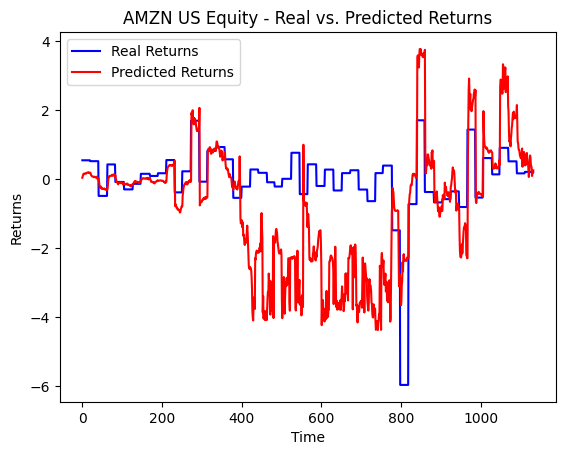

y vs y_pred: (548,) vs (548, 1)


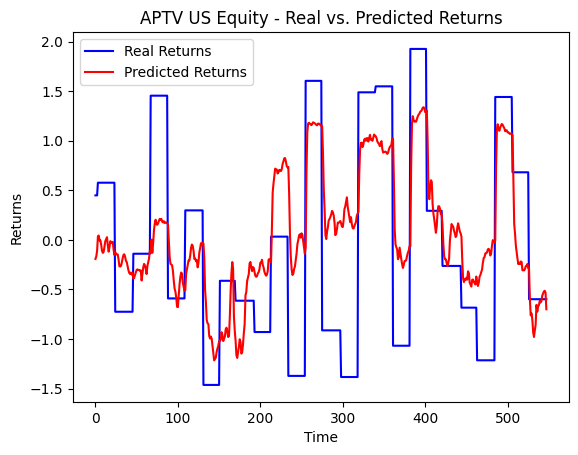

y vs y_pred: (1133,) vs (1133, 1)


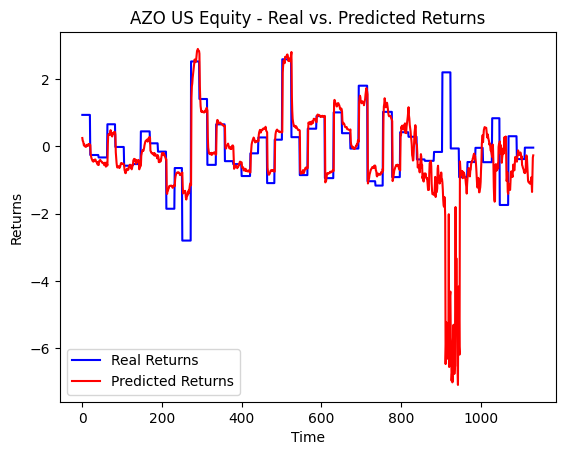

y vs y_pred: (1133,) vs (1133, 1)


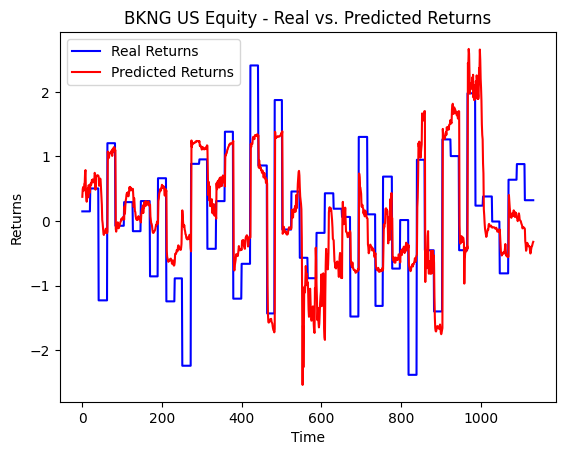

y vs y_pred: (1133,) vs (1133, 1)


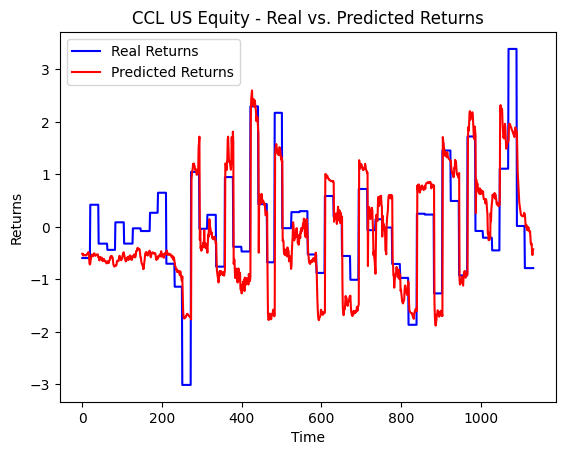

y vs y_pred: (841,) vs (841, 1)


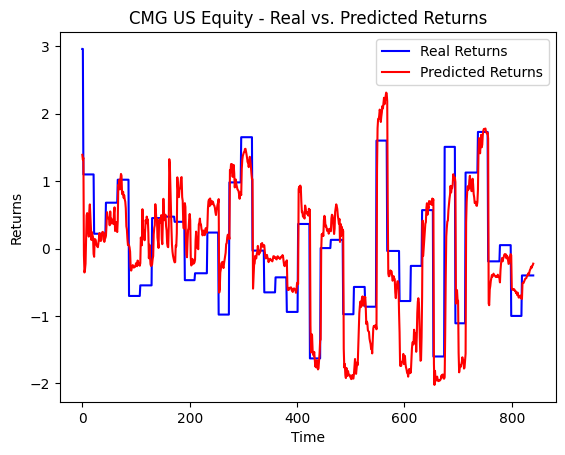

y vs y_pred: (631,) vs (631, 1)


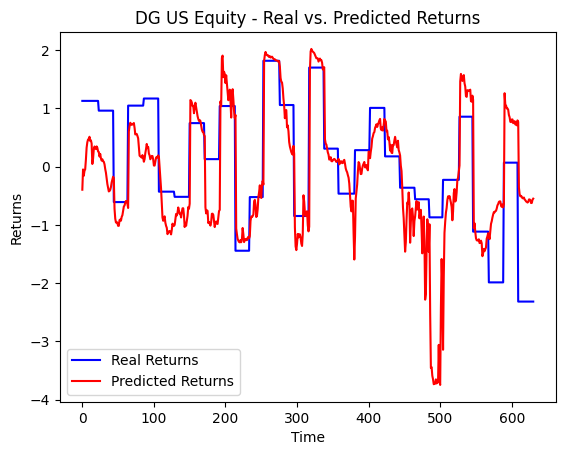

y vs y_pred: (1133,) vs (1133, 1)


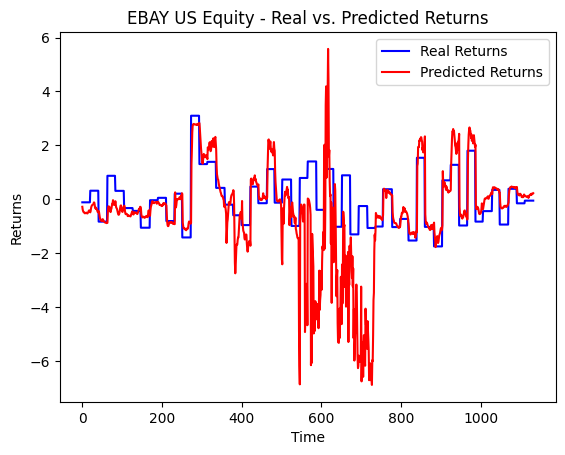

y vs y_pred: (1133,) vs (1133, 1)


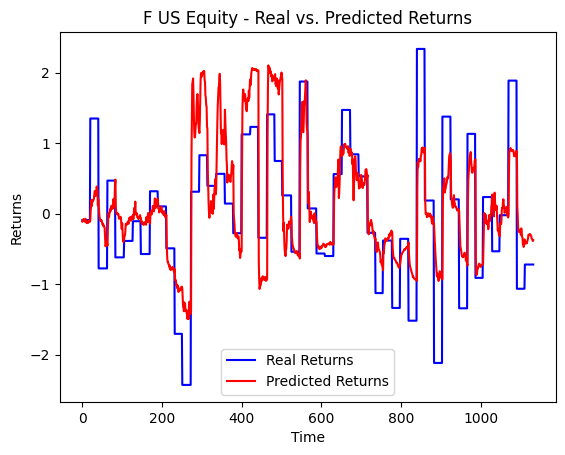

y vs y_pred: (590,) vs (590, 1)


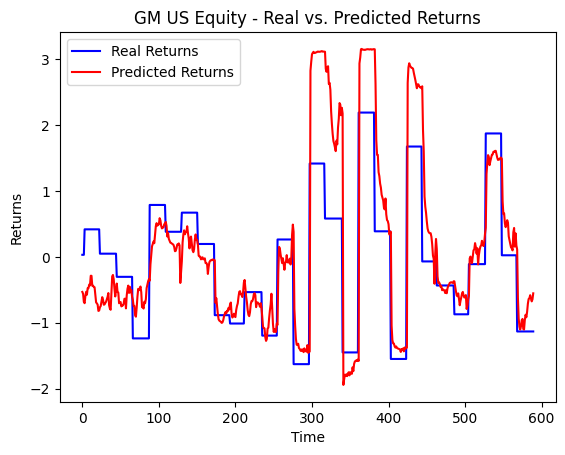

y vs y_pred: (1133,) vs (1133, 1)


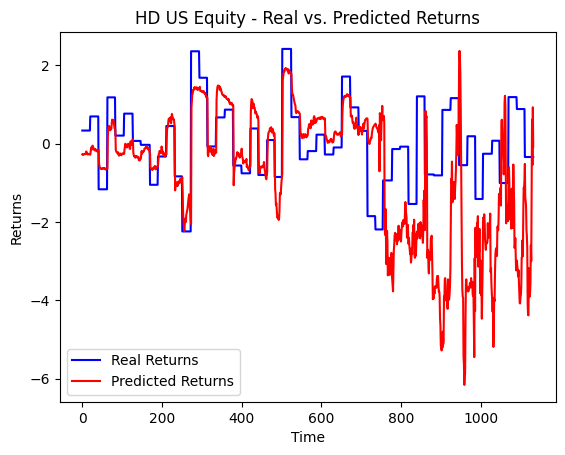

y vs y_pred: (442,) vs (442, 1)


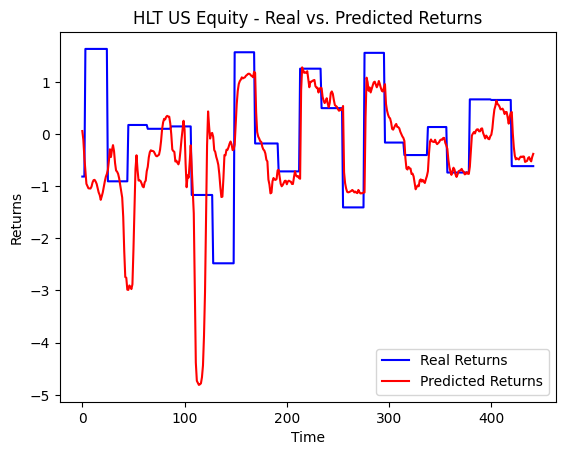

y vs y_pred: (1133,) vs (1133, 1)


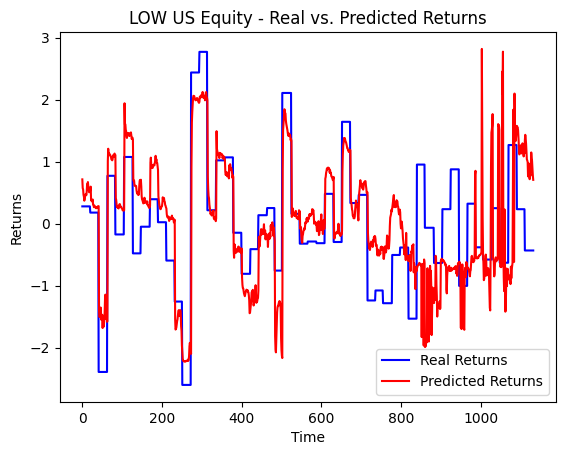

y vs y_pred: (883,) vs (883, 1)


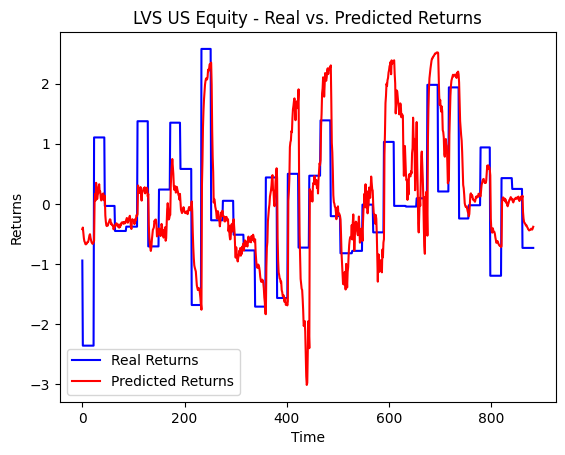

y vs y_pred: (1133,) vs (1133, 1)


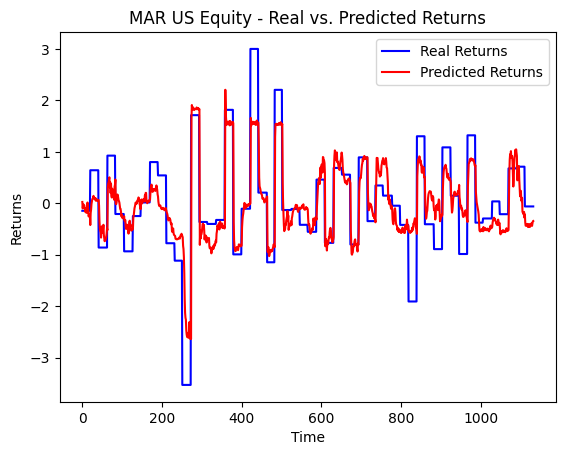

y vs y_pred: (1133,) vs (1133, 1)


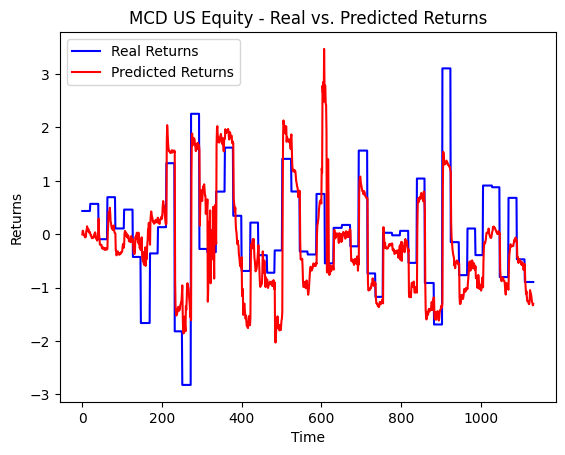

y vs y_pred: (1133,) vs (1133, 1)


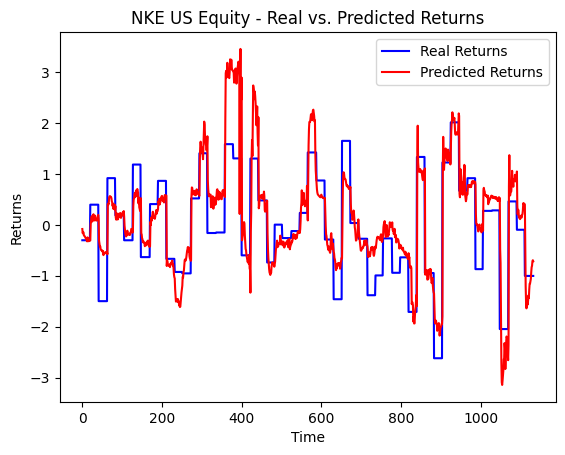

y vs y_pred: (1133,) vs (1133, 1)


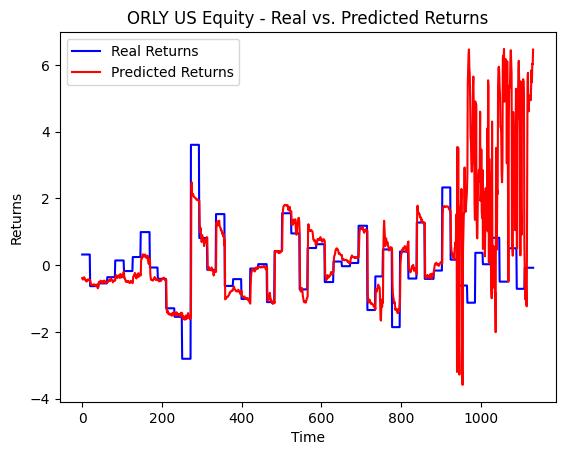

y vs y_pred: (1133,) vs (1133, 1)


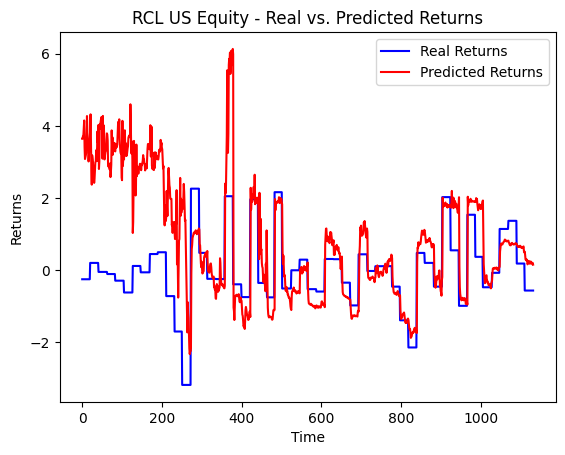

y vs y_pred: (1133,) vs (1133, 1)


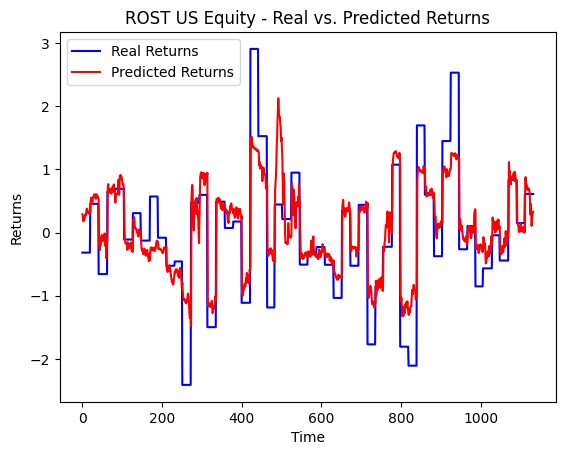

y vs y_pred: (1133,) vs (1133, 1)


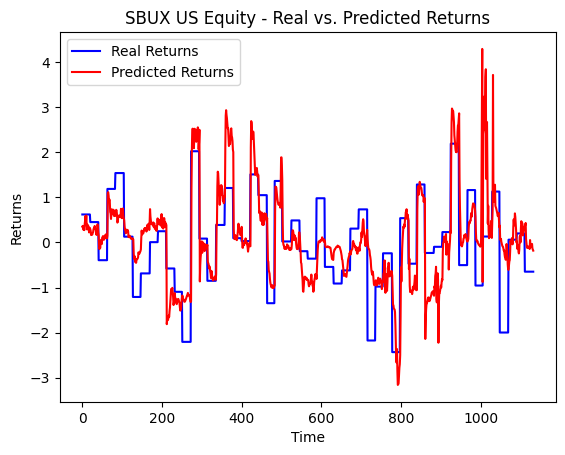

y vs y_pred: (1133,) vs (1133, 1)


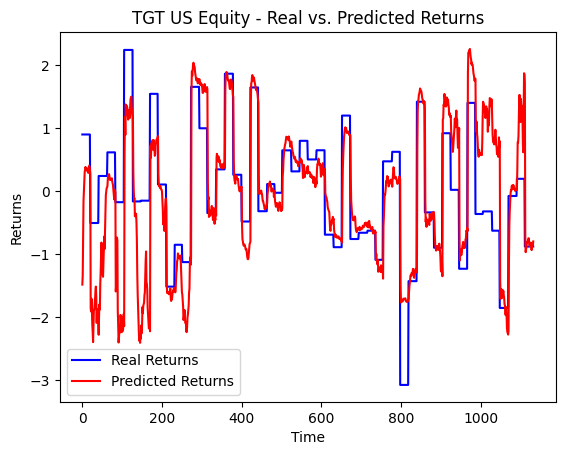

y vs y_pred: (1133,) vs (1133, 1)


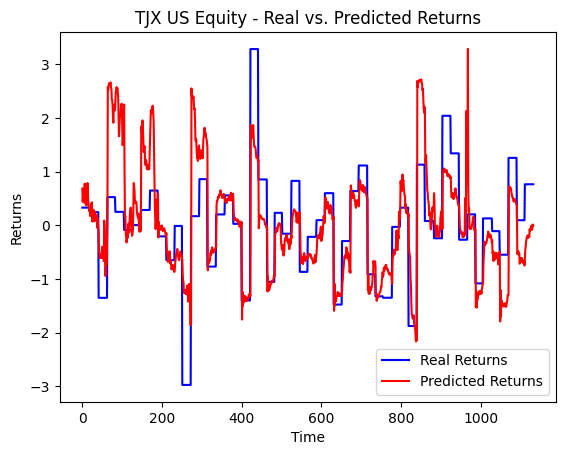

y vs y_pred: (1133,) vs (1133, 1)


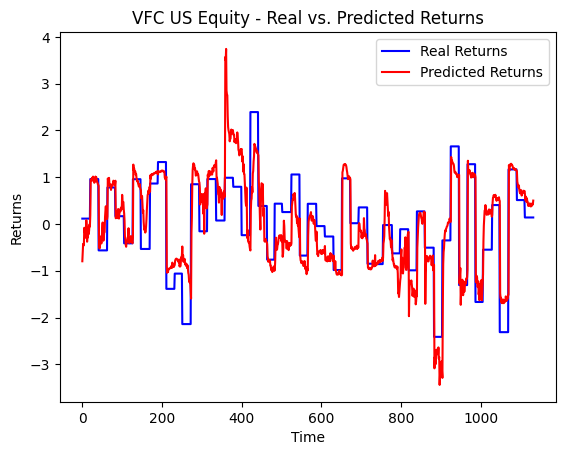

y vs y_pred: (1134,) vs (1134, 1)


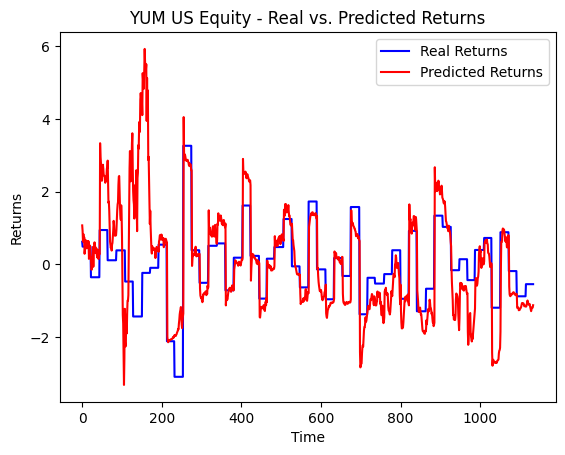

In [ ]:
pred25_cur = analyze(pred25_cur, TASK, mode)


In [ ]:
pred25_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -2.473012   
rmse                                                         1.889416   
mse                                                          3.569892   
y_preds             [[0.04739993], [0.08982779], [0.12776835], [0....   
y                   [0.5519601998264473, 0.5519601998264473, 0.551...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.451627   
rmse                                                         0.771716   
mse                                                          0.595546   
y_preds             [[-0.19286701], [-0.16736656], [-0.11127278], ...   
y                   [0.4487308187640146, 0.4487308187640146, 0.448...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.729522   
rmse                                                         1.333228   
mse                                                          1.777496   
y_preds             [[0.24346611], [0.15881243], [0.1440013], [0.0...   
y                   [0.9301083786080782, 0.9301083786080782, 0.930...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.440401   
rmse                                                         0.753898   
mse                                                          0.568362   
y_preds             [[0.37438688], [0.49257374], [0.52531093], [0....   
y                   [0.14869374547027558, 0.14869374547027558, 0.1...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.574511   
rmse                                                         0.660638   
mse                                                          0.436442   
y_preds             [[-0.51199603], [-0.50748116], [-0.5462373], [...   
y                   [-0.5926962172529414, -0.5926962172529414, -0....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.536265   
rmse                                                         0.596148   
mse                                                          0.355392   
y_preds             [[1.3908166], [1.3188086], [1.3470024], [-0.10...   
y                   [2.961901351418715, 2.961901351418715, 1.09997...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.343604   
rmse                                                           0.8352   
mse                                                          0.697559   
y_preds             [[-0.39726913], [-0.049817808], [-0.15868796],...   
y                   [1.1263811777176158, 1.1263811777176158, 1.126...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           -1.76827   
rmse                                                         1.635086   
mse                                                          2.673505   
y_preds             [[-0.28227448], [-0.3902894], [-0.44267663], [...   
y                   [-0.115968458

In [ ]:
def save_predictions(df, signature = None, note = ''):
  for column_name in df.columns:
    stock_y_true = df.loc['y',column_name]
    stock_y_preds = df.loc['y_preds',column_name]
    stock_pred_df = pd.DataFrame({'y': stock_y_true, 'y_preds': stock_y_preds.flatten()})
    stock_pred_df.to_csv(f'/content/gdrive/MyDrive/lazard/predictions/{signature}/{note}{column_name}_ypreds.csv', index = False)


In [ ]:

save_predictions(pred25_cur, signature = 'LSTM_pricecf_2000/current/sep', note = 'epoch7')

### One model all stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'agg'

pred25_aggregate_cur = train_aggregate_model(train_df = dfall, val_df = df25, task = TASK, N_epoch = 7)

Epoch 1/7
2625/2625 [==============================] - ETA: 0s - loss: 0.2692
Epoch 1: val_loss improved from inf to 0.21694, saving model to weights_task_current_aggregate_model.h5
2625/2625 [==============================] - 45s 15ms/step - loss: 0.2692 - val_loss: 0.2169 - lr: 0.0100
Epoch 2/7
2624/2625 [============================>.] - ETA: 0s - loss: 0.2195
Epoch 2: val_loss improved from 0.21694 to 0.21424, saving model to weights_task_current_aggregate_model.h5
2625/2625 [==============================] - 36s 14ms/step - loss: 0.2194 - val_loss: 0.2142 - lr: 0.0100
Epoch 3/7
2621/2625 [============================>.] - ETA: 0s - loss: 0.1936
Epoch 3: val_loss improved from 0.21424 to 0.18246, saving model to weights_task_current_aggregate_model.h5
2625/2625 [==============================] - 36s 14ms/step - loss: 0.1935 - val_loss: 0.1825 - lr: 0.0100
Epoch 4/7
2625/2625 [==============================] - ETA: 0s - loss: 0.1944
Epoch 4: val_loss did not improve from 0.18246
262

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
36/36 [==============================] - 1s 5ms/step


-------------------APTV US Equity--------------------
18/18 [==============================] - 0s 5ms/step


-------------------AZO US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------BKNG US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------CCL US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------CMG US Equity--------------------
27/27 [==============================] - 0s 5ms/step


-------------------DG US Equity--------------------
20/20 [==============================] - 0s 5ms/step


-------------------EBAY US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------F US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------GM US 

y vs y_pred: (1133,) vs (1133, 1)


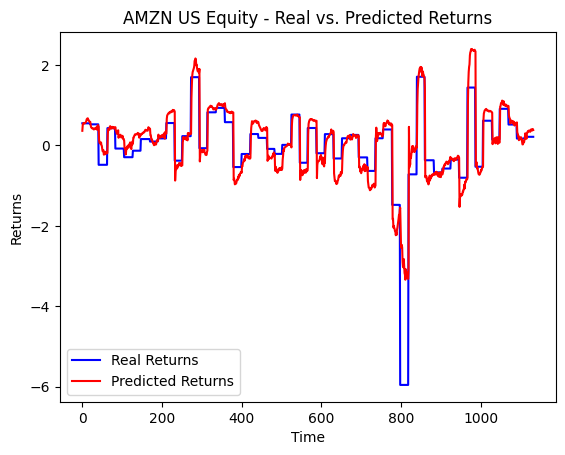

y vs y_pred: (548,) vs (548, 1)


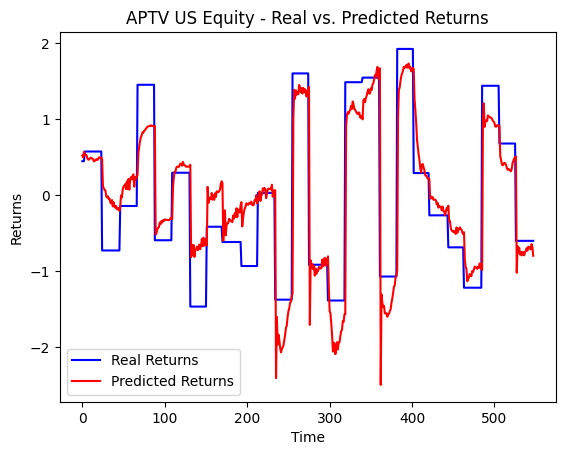

y vs y_pred: (1133,) vs (1133, 1)


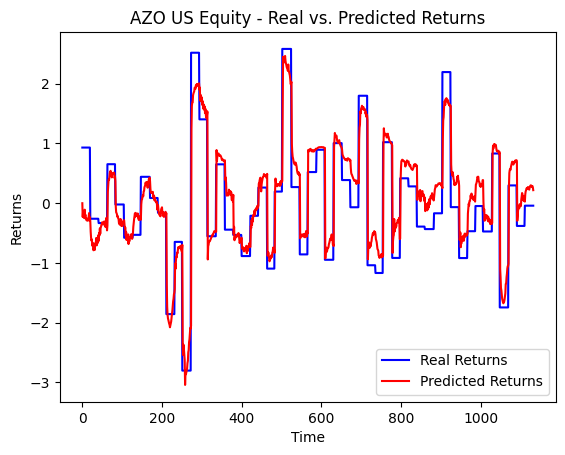

y vs y_pred: (1133,) vs (1133, 1)


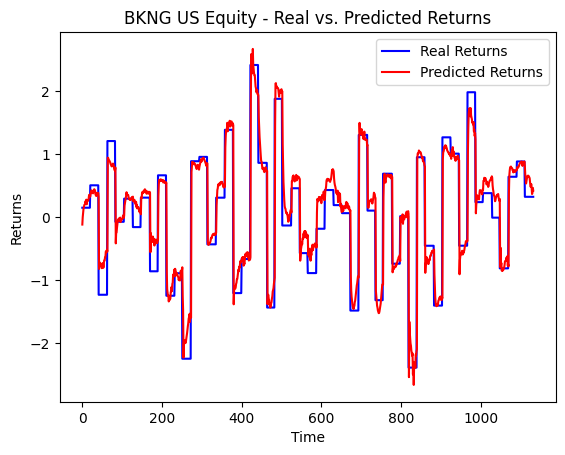

y vs y_pred: (1133,) vs (1133, 1)


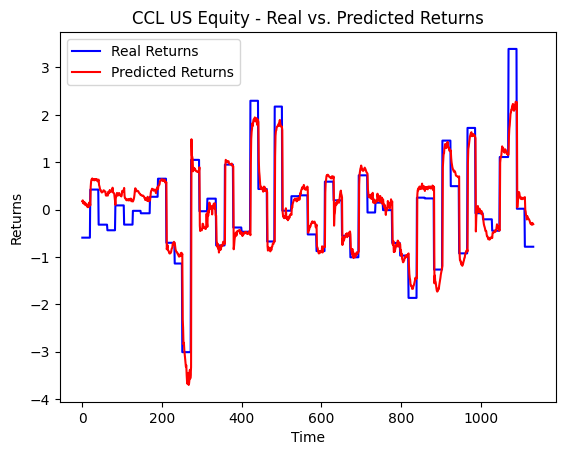

y vs y_pred: (841,) vs (841, 1)


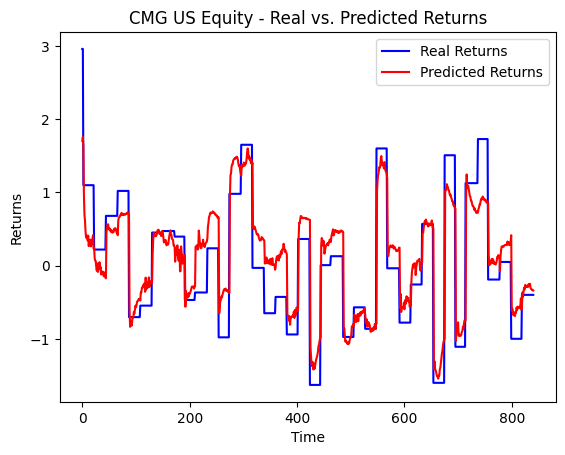

y vs y_pred: (631,) vs (631, 1)


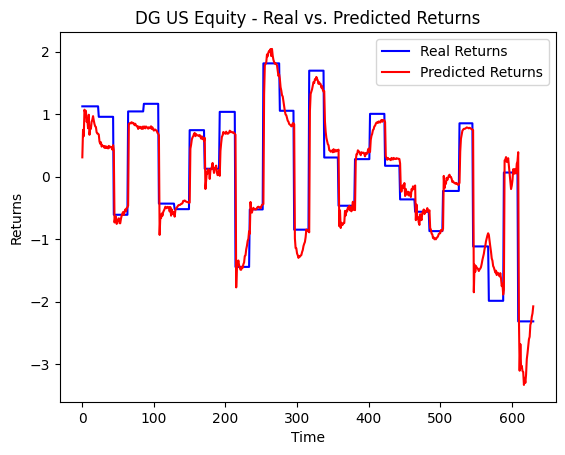

y vs y_pred: (1133,) vs (1133, 1)


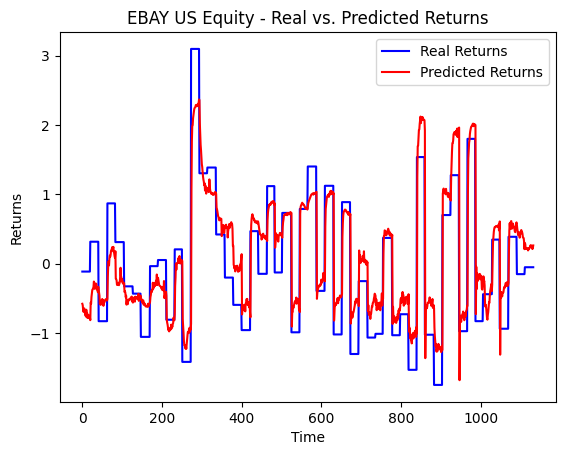

y vs y_pred: (1133,) vs (1133, 1)


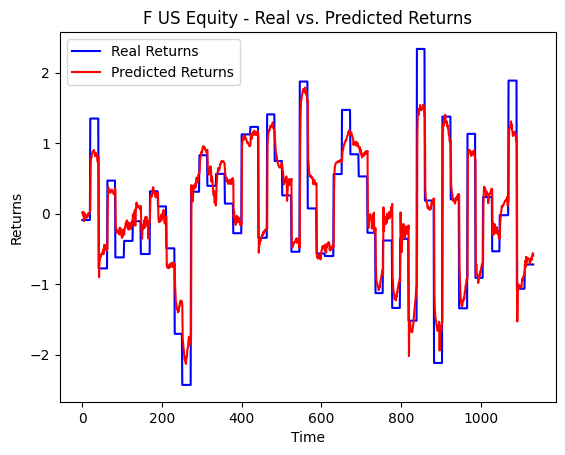

y vs y_pred: (590,) vs (590, 1)


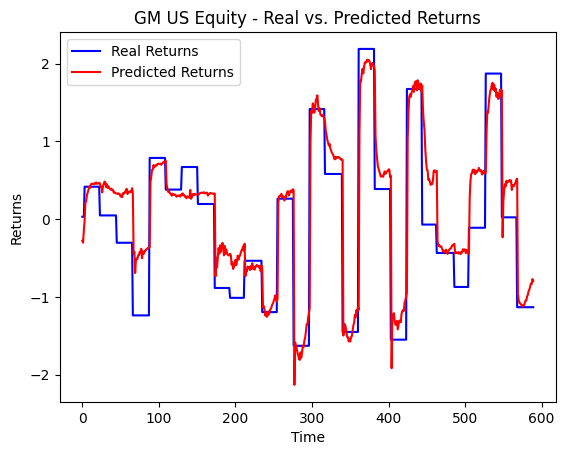

y vs y_pred: (1133,) vs (1133, 1)


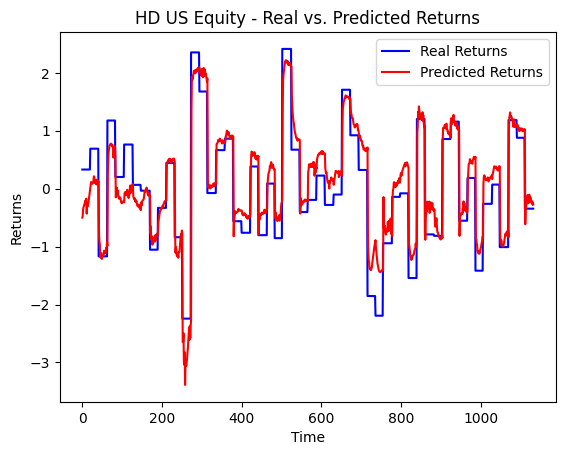

y vs y_pred: (442,) vs (442, 1)


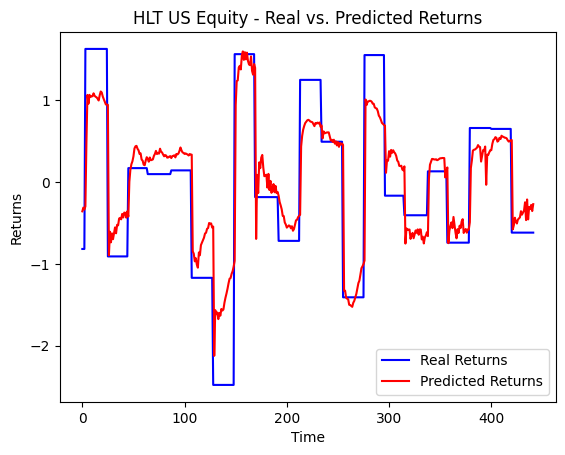

y vs y_pred: (1133,) vs (1133, 1)


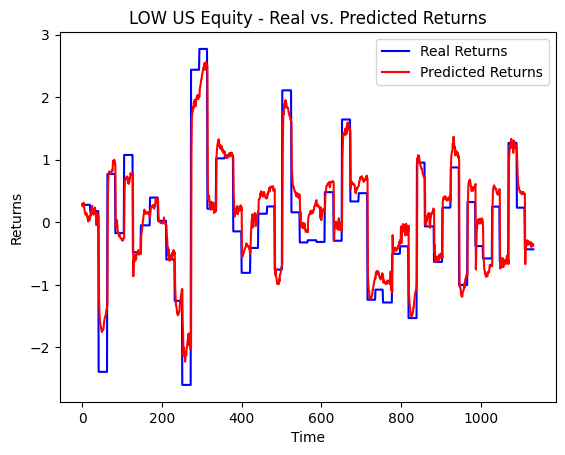

y vs y_pred: (883,) vs (883, 1)


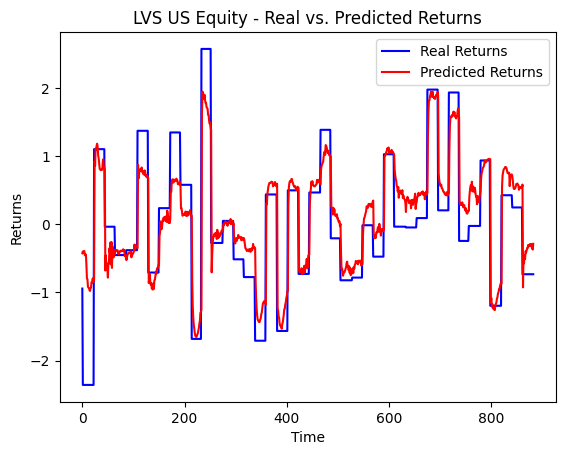

y vs y_pred: (1133,) vs (1133, 1)


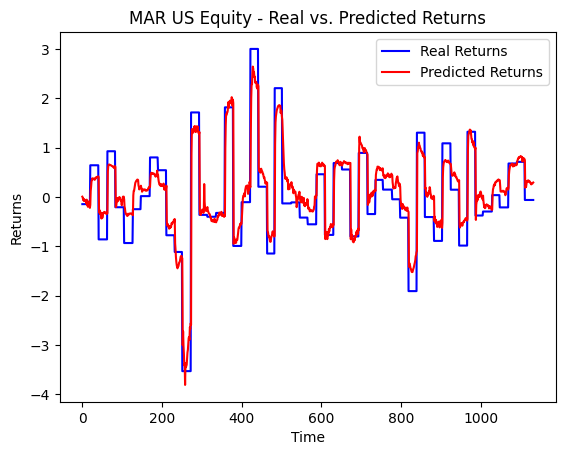

y vs y_pred: (1133,) vs (1133, 1)


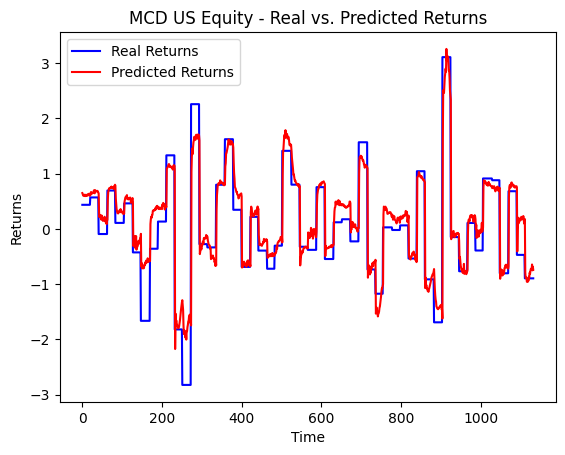

y vs y_pred: (1133,) vs (1133, 1)


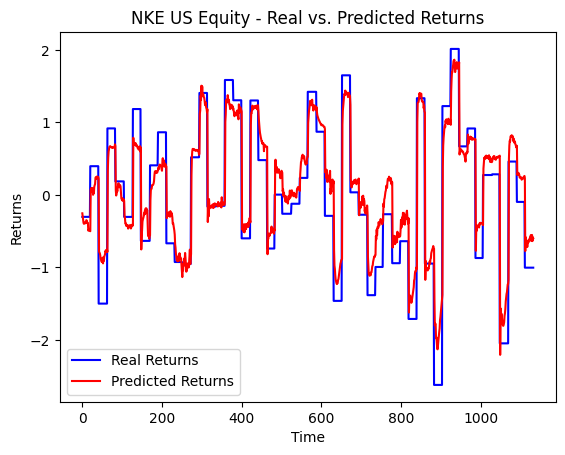

y vs y_pred: (1133,) vs (1133, 1)


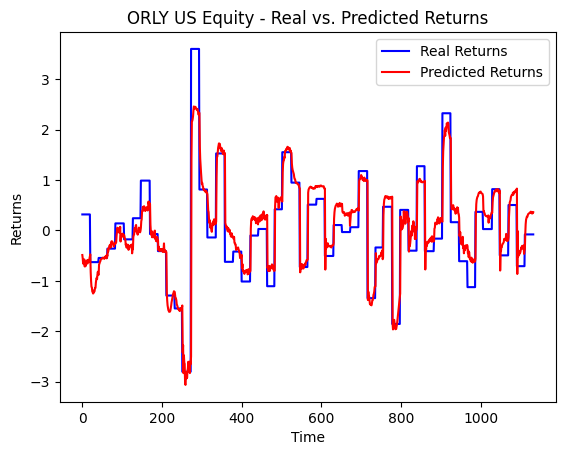

y vs y_pred: (1133,) vs (1133, 1)


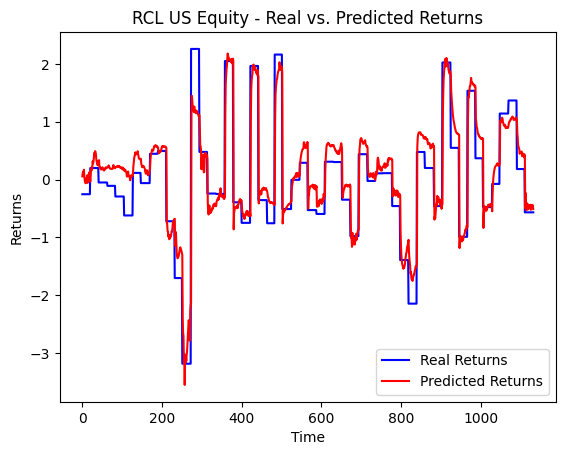

y vs y_pred: (1133,) vs (1133, 1)


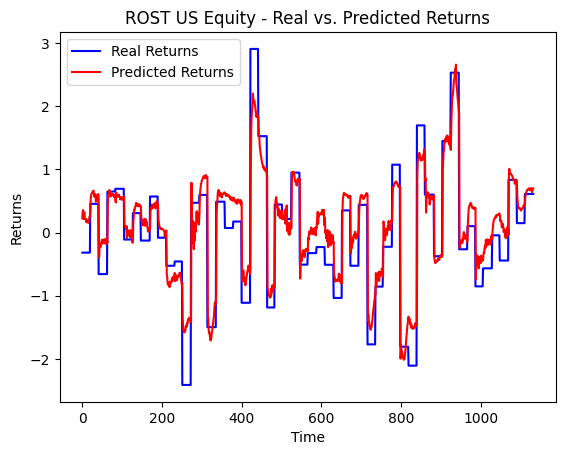

y vs y_pred: (1133,) vs (1133, 1)


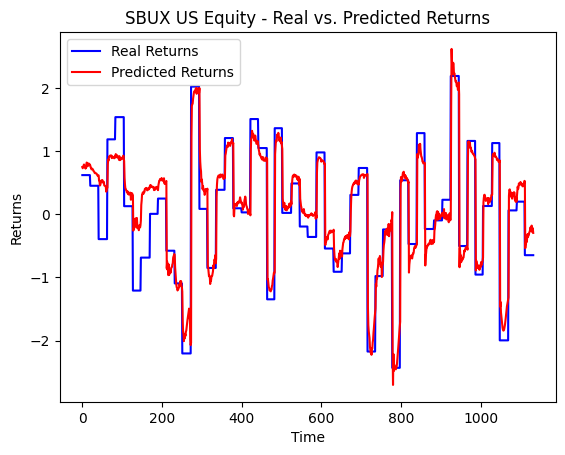

y vs y_pred: (1133,) vs (1133, 1)


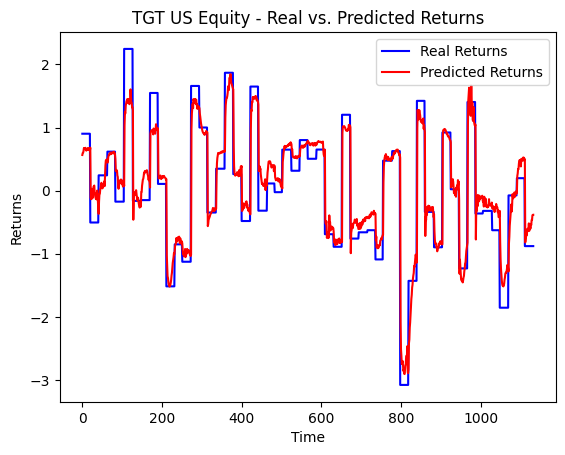

y vs y_pred: (1133,) vs (1133, 1)


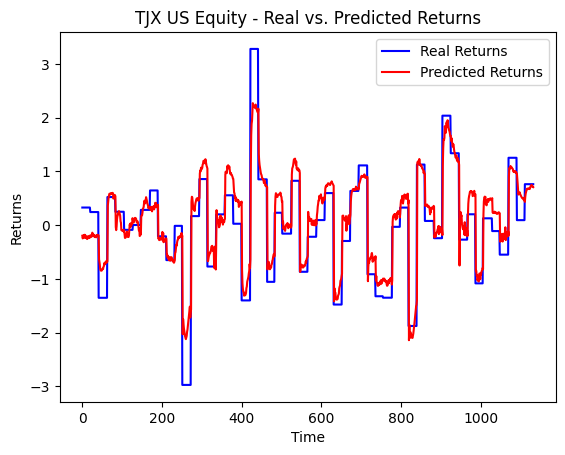

y vs y_pred: (1133,) vs (1133, 1)


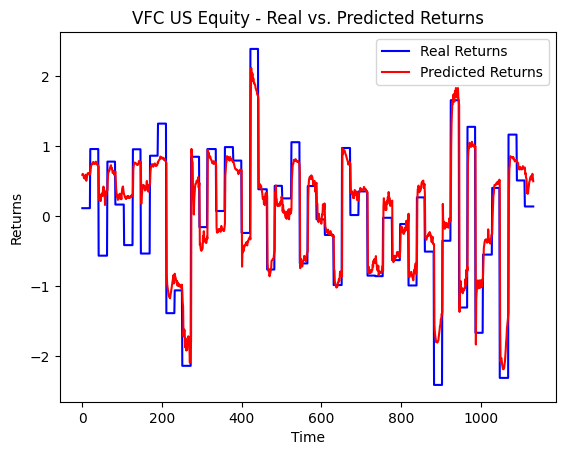

y vs y_pred: (1134,) vs (1134, 1)


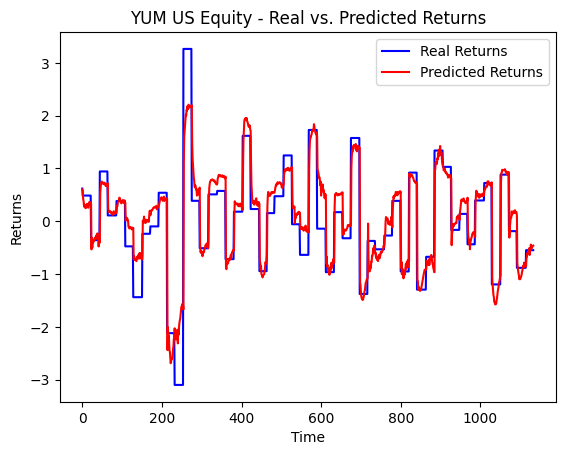

In [ ]:
pred25_aggregate_cur = analyze(pred25_aggregate_cur, TASK, mode)


In [ ]:
pred25_aggregate_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.714246   
rmse                                                         0.541964   
mse                                                          0.293725   
y_preds             [[0.36546808], [0.501075], [0.5484895], [0.546...   
y                   [0.5519601998264473, 0.5519601998264473, 0.551...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.753581   
rmse                                                         0.517316   
mse                                                          0.267616   
y_preds             [[0.5238405], [0.49959487], [0.5734614], [0.53...   
y                   [0.4487308187640146, 0.4487308187640146, 0.448...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.788276   
rmse                                                         0.466473   
mse                                                          0.217597   
y_preds             [[-0.0013594031], [-0.23150647], [-0.13150609]...   
y                   [0.9301083786080782, 0.9301083786080782, 0.930...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.844706   
rmse                                                         0.397147   
mse                                                          0.157726   
y_preds             [[-0.117795825], [-0.0007736087], [0.06520879]...   
y                   [0.14869374547027558, 0.14869374547027558, 0.1...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.796405   
rmse                                                         0.456986   
mse                                                          0.208836   
y_preds             [[0.1734013], [0.19523728], [0.13385886], [0.1...   
y                   [-0.5926962172529414, -0.5926962172529414, -0....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.741119   
rmse                                                          0.44542   
mse                                                          0.198399   
y_preds             [[1.7029793], [1.7597324], [1.6303827], [0.954...   
y                   [2.961901351418715, 2.961901351418715, 1.09997...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.865517   
rmse                                                         0.378043   
mse                                                          0.142916   
y_preds             [[0.30978286], [0.750359], [0.6485369], [1.072...   
y                   [1.1263811777176158, 1.1263811777176158, 1.126...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.724759   
rmse                                                         0.515576   
mse                                                          0.265819   
y_preds             [[-0.5807408], [-0.6016928], [-0.66299355], [-...   
y                   [-0.115968458

In [ ]:
save_predictions(pred25_aggregate_cur, signature = 'LSTM_pricecf_2000/current/agg', note = 'epoch7')

## Task: predict 'MONTHLY_RETURN_F1'

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

### Separate model each stock

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'sep'
pred25_next = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.2318
Epoch 1: val_loss improved from inf to 0.39314, saving model to weights_task_next_AMZN US Equity_model.h5
117/117 [==============================] - 9s 27ms/step - loss: 1.2283 - val_loss: 0.3931 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 1.1001
Epoch 2: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0926 - val_loss: 0.4970 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0636
Epoch 3: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0668 - val_loss: 0.4629 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 1.0902
Epoch 4: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0919 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
56/57 [============================>.] - ETA: 0s - loss: 0.8131
Epoch 1: val_loss improved from inf to 2.11388, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 8s 36ms/step - loss: 0.8130 - val_loss: 2.1139 - lr: 0.0100
Epoch 2/30
56/57 [============================>.] - ETA: 0s - loss: 0.5661
Epoch 2: val_loss improved from 2.11388 to 2.10734, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 1s 15ms/step - loss: 0.5634 - val_loss: 2.1073 - lr: 0.0100
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.4469
Epoch 3: val_loss improved from 2.10734 to 2.02128, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 1s 15ms/step - loss: 0.4469 - val_loss: 2.0213 - lr: 0.0100
Epoch 4/30
54/57 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1s 5ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 0.9545
Epoch 1: val_loss improved from inf to 0.75960, saving model to weights_task_next_AZO US Equity_model.h5
117/117 [==============================] - 11s 25ms/step - loss: 0.9552 - val_loss: 0.7596 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.8996
Epoch 2: val_loss did not improve from 0.75960
117/117 [==============================] - 2s 14ms/step - loss: 0.8996 - val_loss: 0.7844 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.8758
Epoch 3: val_loss did not improve from 0.75960
117/117 [==============================] - 2s 14ms/step - loss: 0.8749 - val_loss: 0.8676 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.8379
Epoch 4: val_loss improved from 0.75960 to 0.71077, saving model to weights

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.2102
Epoch 1: val_loss improved from inf to 0.13396, saving model to weights_task_next_BKNG US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.2094 - val_loss: 0.1340 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.0725
Epoch 2: val_loss improved from 0.13396 to 0.11838, saving model to weights_task_next_BKNG US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0701 - val_loss: 0.1184 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9428
Epoch 3: val_loss did not improve from 0.11838
117/117 [==============================] - 2s 14ms/step - loss: 0.9409 - val_loss: 0.1243 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.7372
Epoch 4: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 1.0575
Epoch 1: val_loss improved from inf to 0.61934, saving model to weights_task_next_CCL US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0575 - val_loss: 0.6193 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.8916
Epoch 2: val_loss did not improve from 0.61934
117/117 [==============================] - 2s 14ms/step - loss: 0.8959 - val_loss: 1.0767 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 0.8408
Epoch 3: val_loss did not improve from 0.61934
117/117 [==============================] - 2s 14ms/step - loss: 0.8408 - val_loss: 0.8291 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.7995
Epoch 4: val_loss did not improve from 0.61934
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 1.0382
Epoch 1: val_loss improved from inf to 0.96022, saving model to weights_task_next_CMG US Equity_model.h5
87/87 [==============================] - 8s 29ms/step - loss: 1.0382 - val_loss: 0.9602 - lr: 0.0100
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9779
Epoch 2: val_loss did not improve from 0.96022
87/87 [==============================] - 1s 14ms/step - loss: 0.9779 - val_loss: 1.2471 - lr: 0.0100
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.9533
Epoch 3: val_loss did not improve from 0.96022
87/87 [==============================] - 1s 15ms/step - loss: 0.9522 - val_loss: 0.9647 - lr: 0.0100
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 0.8813
Epoch 4: val_loss improved from 0.96022 to 0.88620, saving model to weights_task_next_CMG 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 5ms/step


-------------------DG US Equity--------------------
Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 1.1245
Epoch 1: val_loss improved from inf to 3.86185, saving model to weights_task_next_DG US Equity_model.h5
68/68 [==============================] - 8s 33ms/step - loss: 1.1245 - val_loss: 3.8619 - lr: 0.0100
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 0.8721
Epoch 2: val_loss improved from 3.86185 to 1.82847, saving model to weights_task_next_DG US Equity_model.h5
68/68 [==============================] - 1s 15ms/step - loss: 0.8733 - val_loss: 1.8285 - lr: 0.0100
Epoch 3/30
66/68 [============================>.] - ETA: 0s - loss: 0.7248
Epoch 3: val_loss did not improve from 1.82847
68/68 [==============================] - 1s 15ms/step - loss: 0.7235 - val_loss: 3.0353 - lr: 0.0100
Epoch 4/30
66/68 [============================>.] - ETA: 0s - loss: 0.5529
Epoch 4: val_loss did not impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 5ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 1.1349
Epoch 1: val_loss improved from inf to 0.54814, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 11s 25ms/step - loss: 1.1349 - val_loss: 0.5481 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 1.0739
Epoch 2: val_loss improved from 0.54814 to 0.54385, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0711 - val_loss: 0.5439 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0250
Epoch 3: val_loss improved from 0.54385 to 0.52615, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0298 - val_loss: 0.5262 - lr: 0.0100
Epoch 4/30
116/117 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------F US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.2130
Epoch 1: val_loss improved from inf to 0.39983, saving model to weights_task_next_F US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.2022 - val_loss: 0.3998 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 1.0950
Epoch 2: val_loss improved from 0.39983 to 0.26956, saving model to weights_task_next_F US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 1.0850 - val_loss: 0.2696 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 1.0656
Epoch 3: val_loss did not improve from 0.26956
117/117 [==============================] - 2s 14ms/step - loss: 1.0815 - val_loss: 0.5735 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 1.0886
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------GM US Equity--------------------
Epoch 1/30
59/62 [===========================>..] - ETA: 0s - loss: 0.7917
Epoch 1: val_loss improved from inf to 2.11986, saving model to weights_task_next_GM US Equity_model.h5
62/62 [==============================] - 8s 34ms/step - loss: 0.7816 - val_loss: 2.1199 - lr: 0.0100
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.6532
Epoch 2: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 15ms/step - loss: 0.6532 - val_loss: 2.5208 - lr: 0.0100
Epoch 3/30
61/62 [============================>.] - ETA: 0s - loss: 0.6149
Epoch 3: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 14ms/step - loss: 0.6138 - val_loss: 2.5368 - lr: 0.0100
Epoch 4/30
61/62 [============================>.] - ETA: 0s - loss: 0.5638
Epoch 4: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 1s 5ms/step


-------------------HD US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.1311
Epoch 1: val_loss improved from inf to 0.50944, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.1284 - val_loss: 0.5094 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 1.0254
Epoch 2: val_loss improved from 0.50944 to 0.49851, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0237 - val_loss: 0.4985 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9188
Epoch 3: val_loss improved from 0.49851 to 0.49774, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.9185 - val_loss: 0.4977 - lr: 0.0100
Epoch 4/30
114/117 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
45/47 [===========================>..] - ETA: 0s - loss: 0.8723
Epoch 1: val_loss improved from inf to 3.87426, saving model to weights_task_next_HLT US Equity_model.h5
47/47 [==============================] - 8s 41ms/step - loss: 0.8752 - val_loss: 3.8743 - lr: 0.0100
Epoch 2/30
45/47 [===========================>..] - ETA: 0s - loss: 0.6717
Epoch 2: val_loss did not improve from 3.87426
47/47 [==============================] - 1s 14ms/step - loss: 0.6638 - val_loss: 6.0132 - lr: 0.0100
Epoch 3/30
44/47 [===========================>..] - ETA: 0s - loss: 0.5244
Epoch 3: val_loss did not improve from 3.87426
47/47 [==============================] - 1s 14ms/step - loss: 0.5330 - val_loss: 4.1677 - lr: 0.0100
Epoch 4/30
46/47 [============================>.] - ETA: 0s - loss: 0.5262
Epoch 4: val_loss did not improve from 3.87426
47/47 [==============================] - 1s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 5ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.0980
Epoch 1: val_loss improved from inf to 0.70925, saving model to weights_task_next_LOW US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0986 - val_loss: 0.7092 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0730
Epoch 2: val_loss did not improve from 0.70925
117/117 [==============================] - 2s 15ms/step - loss: 1.0647 - val_loss: 0.7549 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.9955
Epoch 3: val_loss did not improve from 0.70925
117/117 [==============================] - 2s 14ms/step - loss: 0.9938 - val_loss: 0.7340 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.9387
Epoch 4: val_loss improved from 0.70925 to 0.70098, saving model to weights_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
91/92 [============================>.] - ETA: 0s - loss: 1.2158
Epoch 1: val_loss improved from inf to 0.18105, saving model to weights_task_next_LVS US Equity_model.h5
92/92 [==============================] - 11s 29ms/step - loss: 1.2340 - val_loss: 0.1810 - lr: 0.0100
Epoch 2/30
90/92 [============================>.] - ETA: 0s - loss: 1.0515
Epoch 2: val_loss did not improve from 0.18105
92/92 [==============================] - 1s 14ms/step - loss: 1.0737 - val_loss: 0.2376 - lr: 0.0100
Epoch 3/30
91/92 [============================>.] - ETA: 0s - loss: 1.1483
Epoch 3: val_loss improved from 0.18105 to 0.17407, saving model to weights_task_next_LVS US Equity_model.h5
92/92 [==============================] - 1s 14ms/step - loss: 1.1405 - val_loss: 0.1741 - lr: 0.0100
Epoch 4/30
90/92 [============================>.] - ETA: 0s - loss: 1.0556
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 5ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.2246
Epoch 1: val_loss improved from inf to 0.67346, saving model to weights_task_next_MAR US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.2166 - val_loss: 0.6735 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0806
Epoch 2: val_loss improved from 0.67346 to 0.58989, saving model to weights_task_next_MAR US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 1.0806 - val_loss: 0.5899 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 1.1063
Epoch 3: val_loss did not improve from 0.58989
117/117 [==============================] - 2s 14ms/step - loss: 1.1074 - val_loss: 0.7105 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 1.1025
Epoch 4: val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.0683
Epoch 1: val_loss improved from inf to 0.65775, saving model to weights_task_next_MCD US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0717 - val_loss: 0.6578 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 0.9713
Epoch 2: val_loss did not improve from 0.65775
117/117 [==============================] - 2s 15ms/step - loss: 0.9718 - val_loss: 0.7664 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9394
Epoch 3: val_loss did not improve from 0.65775
117/117 [==============================] - 2s 14ms/step - loss: 0.9335 - val_loss: 0.8071 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 0.8938
Epoch 4: val_loss did not improve from 0.65775
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1291
Epoch 1: val_loss improved from inf to 0.76006, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1293 - val_loss: 0.7601 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0697
Epoch 2: val_loss improved from 0.76006 to 0.73746, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0697 - val_loss: 0.7375 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0296
Epoch 3: val_loss improved from 0.73746 to 0.69722, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0276 - val_loss: 0.6972 - lr: 0.0100
Epoch 4/30
117/117 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1536
Epoch 1: val_loss improved from inf to 0.94089, saving model to weights_task_next_ORLY US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1630 - val_loss: 0.9409 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.1082
Epoch 2: val_loss improved from 0.94089 to 0.55643, saving model to weights_task_next_ORLY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.1190 - val_loss: 0.5564 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0378
Epoch 3: val_loss did not improve from 0.55643
117/117 [==============================] - 2s 15ms/step - loss: 1.0294 - val_loss: 0.6471 - lr: 0.0100
Epoch 4/30
113/117 [===========================>..] - ETA: 0s - loss: 0.9296
Epoch 4: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.1531
Epoch 1: val_loss improved from inf to 0.32853, saving model to weights_task_next_RCL US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.1657 - val_loss: 0.3285 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.1245
Epoch 2: val_loss did not improve from 0.32853
117/117 [==============================] - 2s 14ms/step - loss: 1.1210 - val_loss: 0.3483 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0987
Epoch 3: val_loss did not improve from 0.32853
117/117 [==============================] - 2s 14ms/step - loss: 1.0969 - val_loss: 0.3872 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 1.0944
Epoch 4: val_loss did not improve from 0.32853
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.0074
Epoch 1: val_loss improved from inf to 0.58336, saving model to weights_task_next_ROST US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0046 - val_loss: 0.5834 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.8778
Epoch 2: val_loss did not improve from 0.58336
117/117 [==============================] - 2s 14ms/step - loss: 0.8742 - val_loss: 0.6388 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.6645
Epoch 3: val_loss did not improve from 0.58336
117/117 [==============================] - 2s 14ms/step - loss: 0.6659 - val_loss: 1.0361 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.5211
Epoch 4: val_loss did not improve from 0.58336
117/117 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0277
Epoch 1: val_loss improved from inf to 0.59781, saving model to weights_task_next_SBUX US Equity_model.h5
117/117 [==============================] - 12s 26ms/step - loss: 1.0238 - val_loss: 0.5978 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.8388
Epoch 2: val_loss improved from 0.59781 to 0.50762, saving model to weights_task_next_SBUX US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.8489 - val_loss: 0.5076 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.7375
Epoch 3: val_loss did not improve from 0.50762
117/117 [==============================] - 2s 14ms/step - loss: 0.7391 - val_loss: 0.6213 - lr: 0.0100
Epoch 4/30
117/117 [==============================] - ETA: 0s - loss: 0.6120
Epoch 4: v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.0336
Epoch 1: val_loss improved from inf to 0.69053, saving model to weights_task_next_TGT US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.0334 - val_loss: 0.6905 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 0.9857
Epoch 2: val_loss did not improve from 0.69053
117/117 [==============================] - 2s 14ms/step - loss: 0.9779 - val_loss: 0.7920 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 0.8550
Epoch 3: val_loss did not improve from 0.69053
117/117 [==============================] - 2s 14ms/step - loss: 0.8531 - val_loss: 0.7591 - lr: 0.0100
Epoch 4/30
113/117 [===========================>..] - ETA: 0s - loss: 0.6559
Epoch 4: val_loss did not improve from 0.69053
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1108
Epoch 1: val_loss improved from inf to 0.49663, saving model to weights_task_next_TJX US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1130 - val_loss: 0.4966 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0341
Epoch 2: val_loss did not improve from 0.49663
117/117 [==============================] - 2s 14ms/step - loss: 1.0341 - val_loss: 0.5170 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0476
Epoch 3: val_loss did not improve from 0.49663
117/117 [==============================] - 2s 14ms/step - loss: 1.0477 - val_loss: 0.5115 - lr: 0.0100
Epoch 4/30
117/117 [==============================] - ETA: 0s - loss: 1.0397
Epoch 4: val_loss did not improve from 0.49663
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.0792
Epoch 1: val_loss improved from inf to 0.74079, saving model to weights_task_next_VFC US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0722 - val_loss: 0.7408 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0376
Epoch 2: val_loss did not improve from 0.74079
117/117 [==============================] - 2s 14ms/step - loss: 1.0376 - val_loss: 0.7989 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 1.0261
Epoch 3: val_loss did not improve from 0.74079
117/117 [==============================] - 2s 14ms/step - loss: 1.0261 - val_loss: 0.8134 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 1.0183
Epoch 4: val_loss improved from 0.74079 to 0.71218, saving model to weights_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
113/117 [===========================>..] - ETA: 0s - loss: 1.1258
Epoch 1: val_loss improved from inf to 0.53492, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 8s 24ms/step - loss: 1.1344 - val_loss: 0.5349 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.0745
Epoch 2: val_loss improved from 0.53492 to 0.51694, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 2s 13ms/step - loss: 1.0704 - val_loss: 0.5169 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 1.0626
Epoch 3: val_loss improved from 0.51694 to 0.50256, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 2s 13ms/step - loss: 1.0698 - val_loss: 0.5026 - lr: 0.0100
Epoch 4/30
116/117 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


y vs y_pred: (1133,) vs (1133, 1)


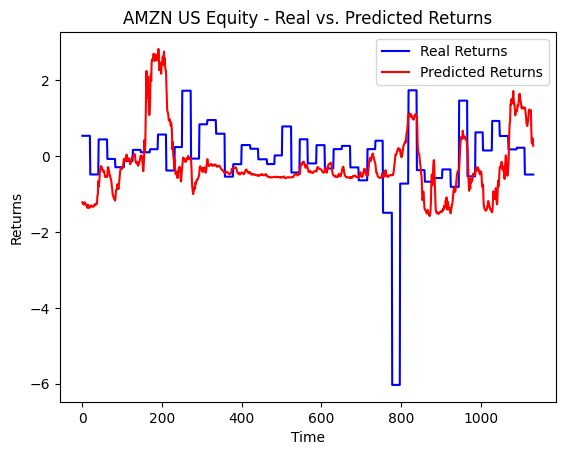

y vs y_pred: (548,) vs (548, 1)


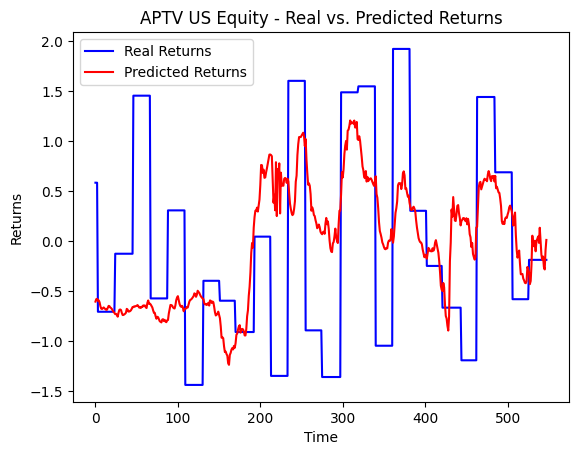

y vs y_pred: (1133,) vs (1133, 1)


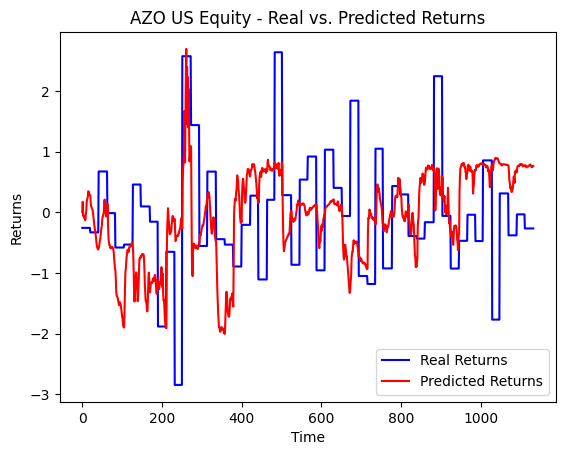

y vs y_pred: (1133,) vs (1133, 1)


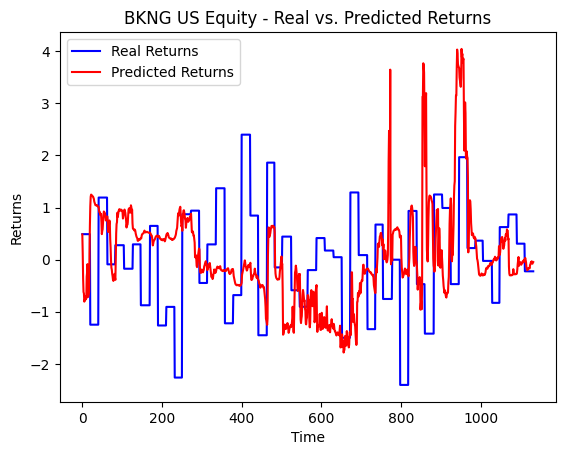

y vs y_pred: (1133,) vs (1133, 1)


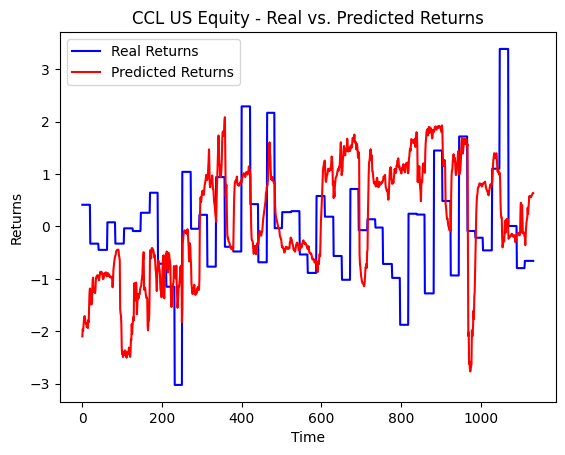

y vs y_pred: (841,) vs (841, 1)


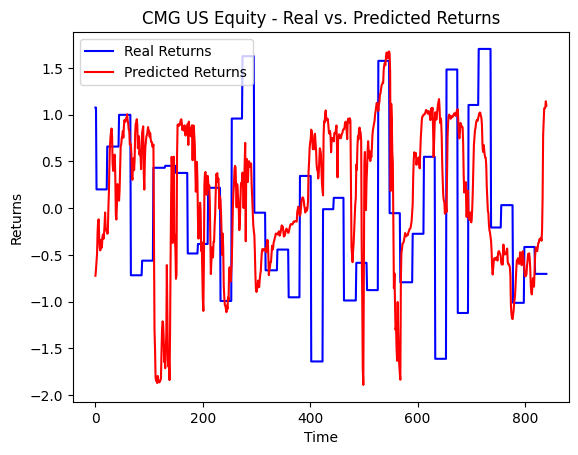

y vs y_pred: (631,) vs (631, 1)


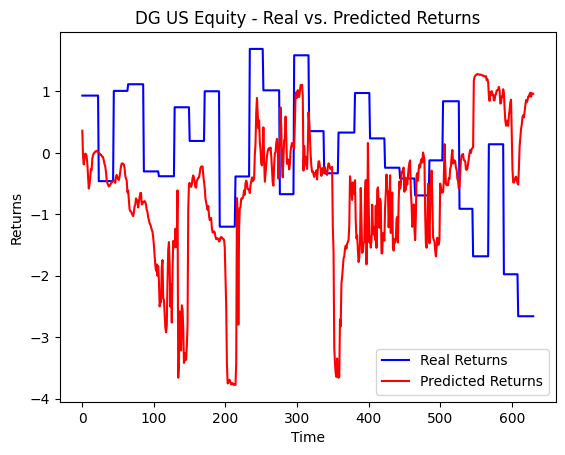

y vs y_pred: (1133,) vs (1133, 1)


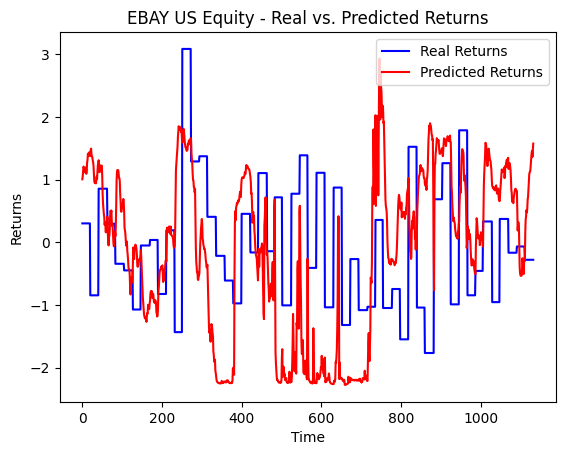

y vs y_pred: (1133,) vs (1133, 1)


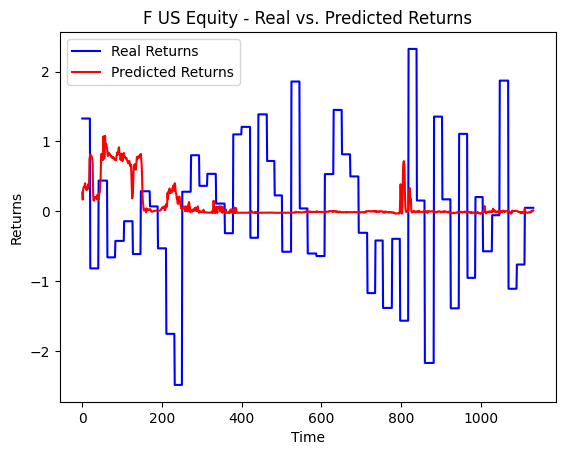

y vs y_pred: (590,) vs (590, 1)


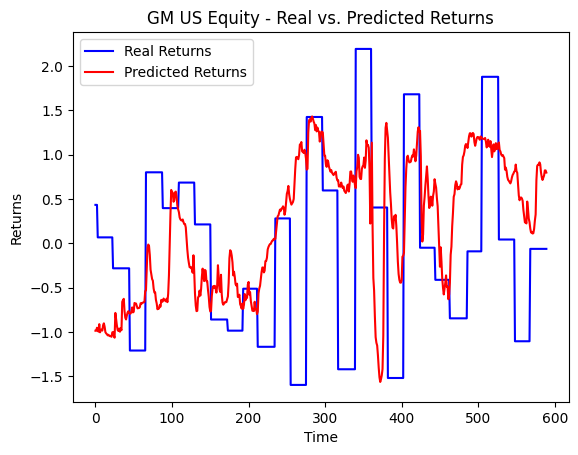

y vs y_pred: (1133,) vs (1133, 1)


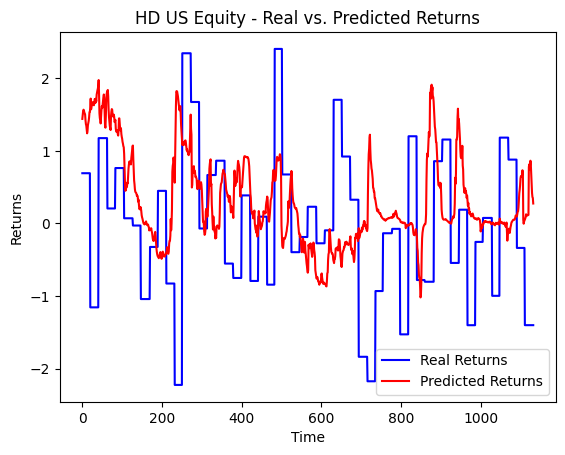

y vs y_pred: (442,) vs (442, 1)


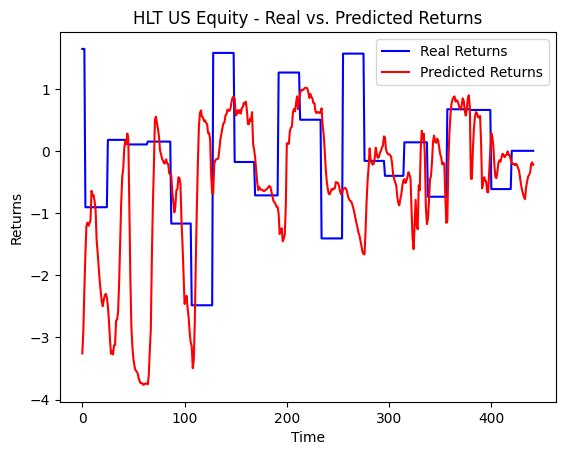

y vs y_pred: (1133,) vs (1133, 1)


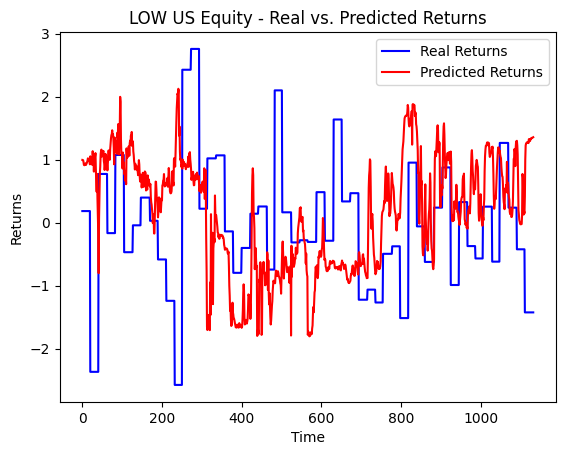

y vs y_pred: (883,) vs (883, 1)


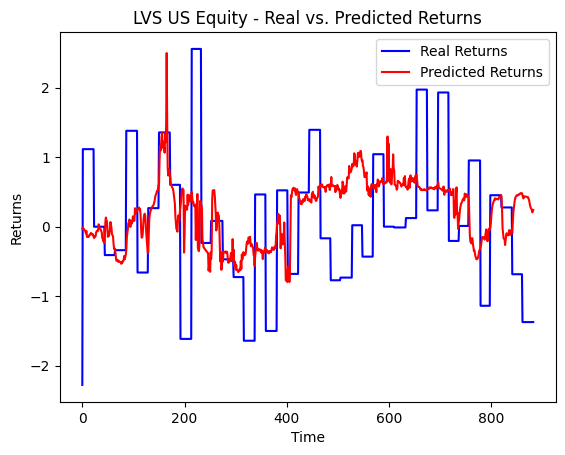

y vs y_pred: (1133,) vs (1133, 1)


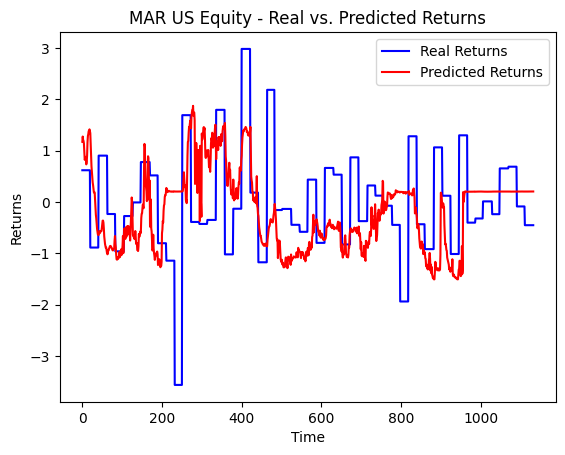

y vs y_pred: (1133,) vs (1133, 1)


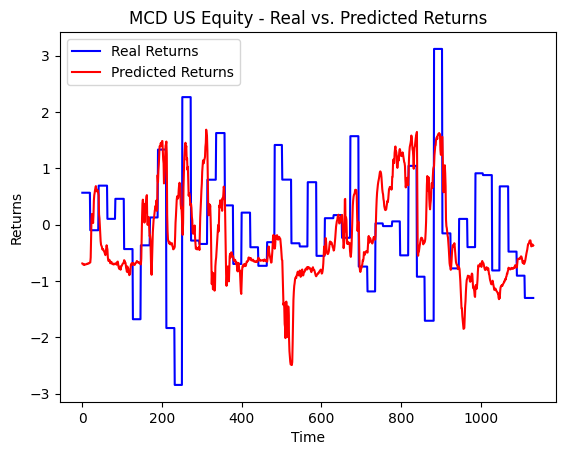

y vs y_pred: (1133,) vs (1133, 1)


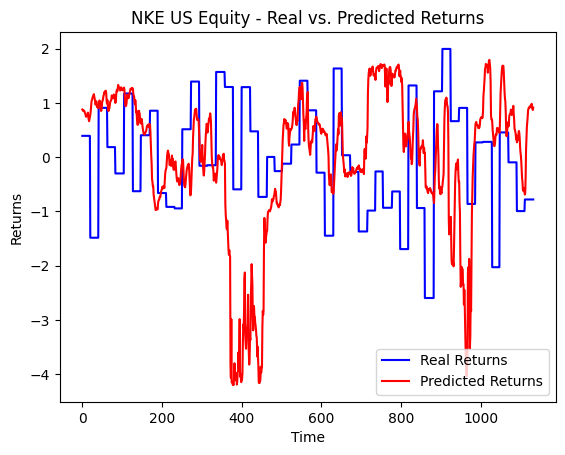

y vs y_pred: (1133,) vs (1133, 1)


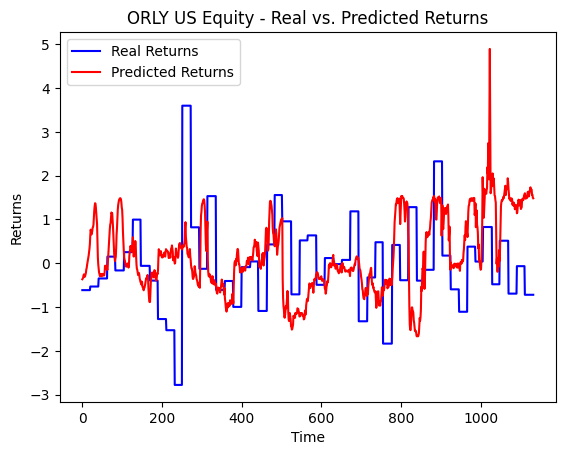

y vs y_pred: (1133,) vs (1133, 1)


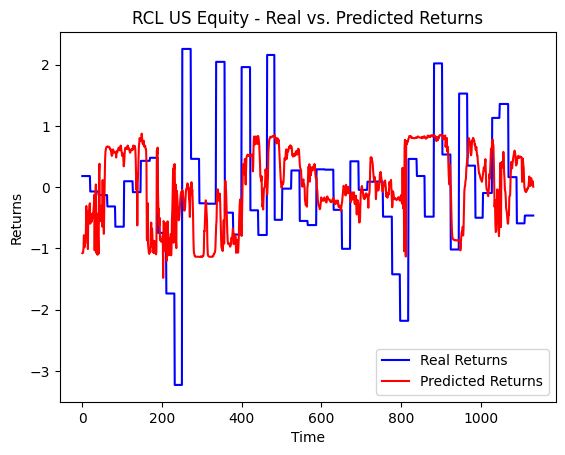

y vs y_pred: (1133,) vs (1133, 1)


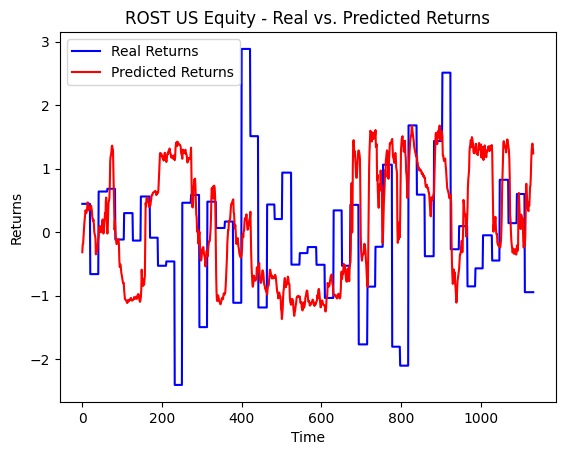

y vs y_pred: (1133,) vs (1133, 1)


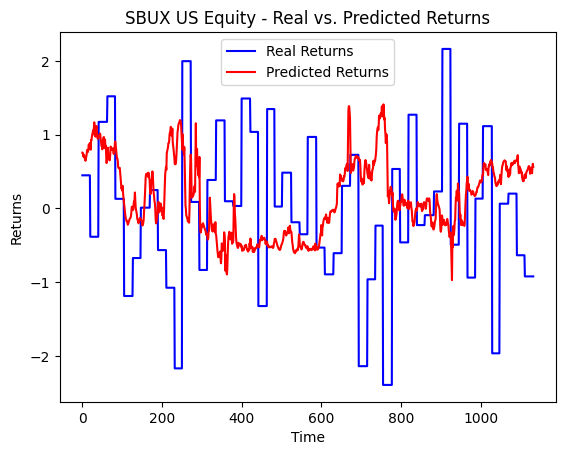

y vs y_pred: (1133,) vs (1133, 1)


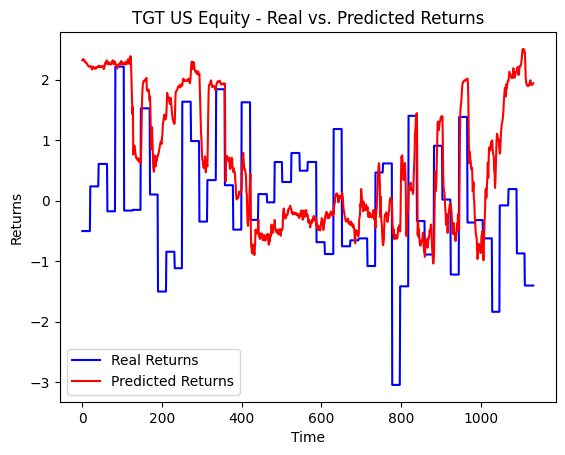

y vs y_pred: (1133,) vs (1133, 1)


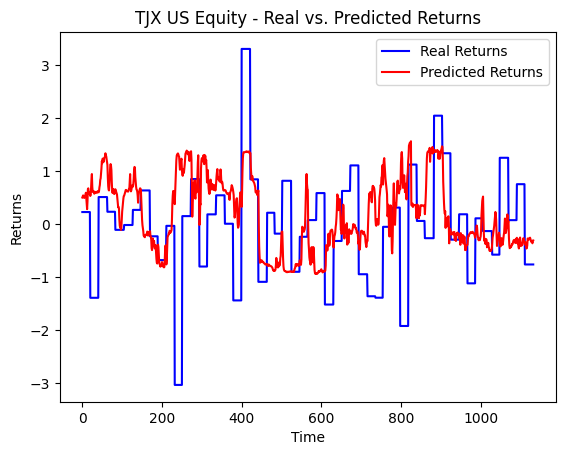

y vs y_pred: (1133,) vs (1133, 1)


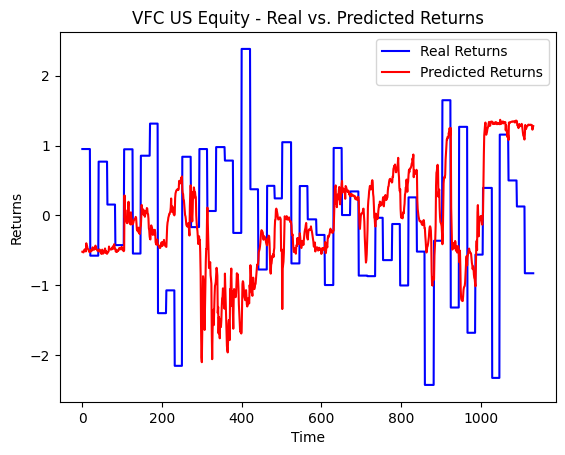

y vs y_pred: (1134,) vs (1134, 1)


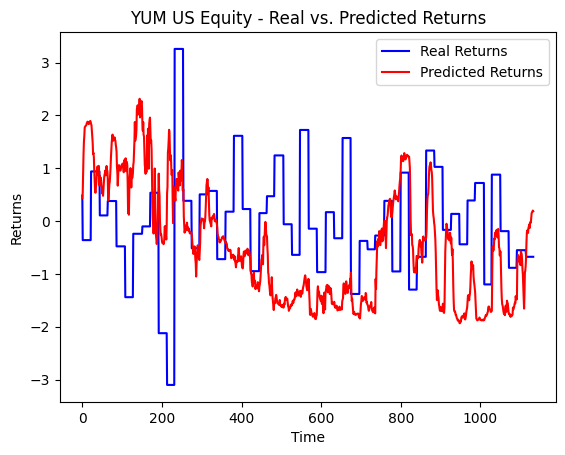

In [ ]:
pred25_next  = analyze(pred25_next, TASK, mode)


In [ ]:
pred25_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.511622   
rmse                                                         1.248365   
mse                                                          1.558415   
y_preds             [[-1.2163408], [-1.2413945], [-1.2412504], [-1...   
y                   [0.5367546248079017, 0.5367546248079017, 0.536...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            0.14683   
rmse                                                         0.959529   
mse                                                          0.920696   
y_preds             [[-0.60622174], [-0.58144295], [-0.5785721], [...   
y                   [0.5849567495341802, 0.5849567495341802, 0.584...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.154581   
rmse                                                          1.07938   
mse                                                          1.165061   
y_preds             [[0.004193023], [0.17290998], [-0.057641193], ...   
y                   [-0.25638270305473004, -0.25638270305473004, -...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.689978   
rmse                                                         1.321188   
mse                                                          1.745537   
y_preds             [[0.48384708], [0.12584388], [-0.36116204], [-...   
y                   [0.48942929069276814, 0.48942929069276814, 0.4...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.861707   
rmse                                                         1.387891   
mse                                                          1.926241   
y_preds             [[-2.0979383], [-1.9592812], [-1.993983], [-1....   
y                   [0.4145305866984984, 0.4145305866984984, 0.414...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.506637   
rmse                                                         1.065208   
mse                                                          1.134669   
y_preds             [[-0.7231983], [-0.65668154], [-0.57522357], [...   
y                   [1.0767576090255748, 1.0767576090255748, 0.200...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            -1.7024   
rmse                                                         1.678207   
mse                                                          2.816378   
y_preds             [[0.36125165], [-0.0638254], [-0.1878124], [-0...   
y                   [0.9324965125999684, 0.9324965125999684, 0.932...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -1.476661   
rmse                                                         1.556774   
mse                                                          2.423545   
y_preds             [[1.007608], [1.0574938], [1.1368624], [1.2108...   
y                   [0.3036816543

In [ ]:
save_predictions(pred25_next, signature = 'LSTM_pricecf_2000/next/sep', note = 'epoch7')

### One model all stock

In [ ]:
"""
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model


"""
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(32),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr, clipvalue=0.5), loss='mean_squared_error')
    return model


def train_aggregate_model_tune(train_df = None, val_df = None, task = None, lr = None,  N_epoch = 70, batchsize = 64):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  y_train = y_train #*100
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  #assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, lr)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  def lr_scheduler(epoch, lr):
    if epoch < 45:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb, lr_scheduler], validation_split=0.2, verbose=1, batch_size=batchsize)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']
    stock_y_val = stock_y_val #*100

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

dfall['X_train'][0].shape

(60, 87)

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

pred25_aggregate_next = train_aggregate_model_tune(train_df = dfall, val_df = df25, lr = 0.005, task = TASK, N_epoch = 2, batchsize = 32)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/2
2625/2625 [==============================] - ETA: 0s - loss: 0.8804
Epoch 1: val_loss improved from inf to 0.94655, saving model to weights_task_next_aggregate_model.h5
2625/2625 [==============================] - 28s 9ms/step - loss: 0.8804 - val_loss: 0.9466 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/2
2621/2625 [============================>.] - ETA: 0s - loss: 0.6450
Epoch 2: val_loss did not improve from 0.94655
2625/2625 [==============================] - 22s 8ms/step - loss: 0.6449 - val_loss: 1.0587 - lr: 0.0050


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
36/36 [==============================] - 1s 4ms/step


-------------------APTV US Equity--------------------
18/18 [==============================] - 0s 4ms/step


-------------------AZO US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------BKNG US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------CCL US Equity--------------------
36/36 [==============================] - 0s 4ms/step


-------------------CMG US Equity--------------------
27/27 [==============================] - 0s 4ms/step


-------------------DG US Equity--------------------
20/20 [==============================] - 0s 4ms/step


-------------------EBAY US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------F US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------GM US 

y vs y_pred: (1133,) vs (1133, 1)


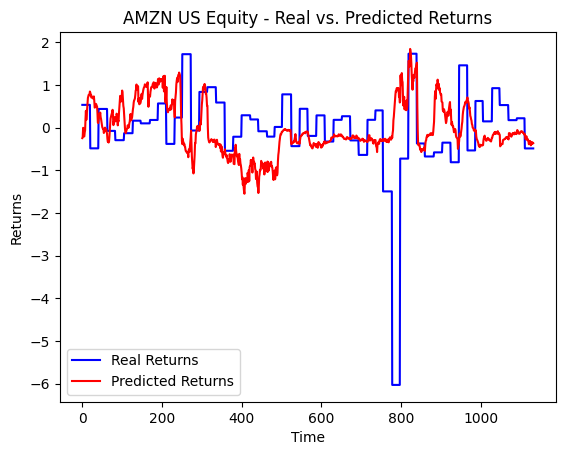

y vs y_pred: (548,) vs (548, 1)


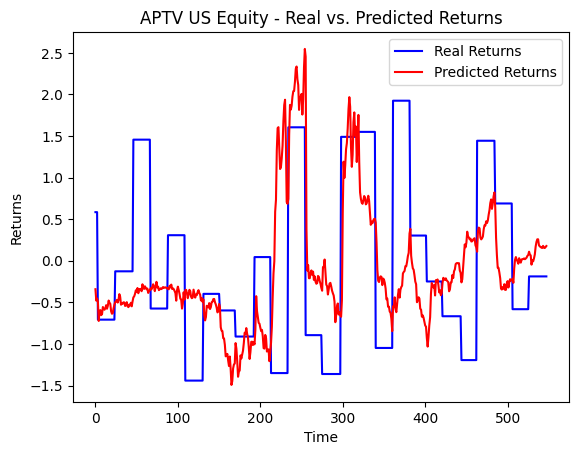

y vs y_pred: (1133,) vs (1133, 1)


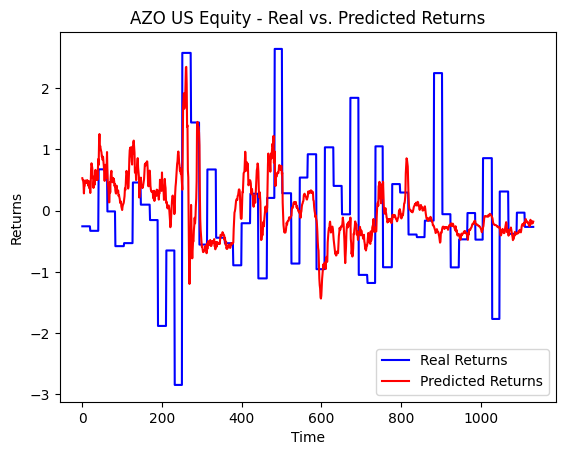

y vs y_pred: (1133,) vs (1133, 1)


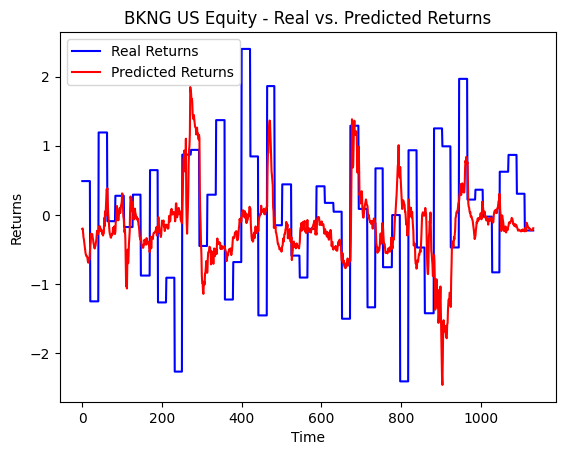

y vs y_pred: (1133,) vs (1133, 1)


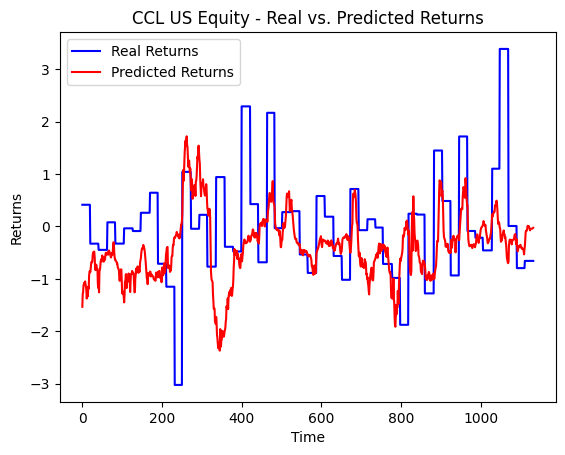

y vs y_pred: (841,) vs (841, 1)


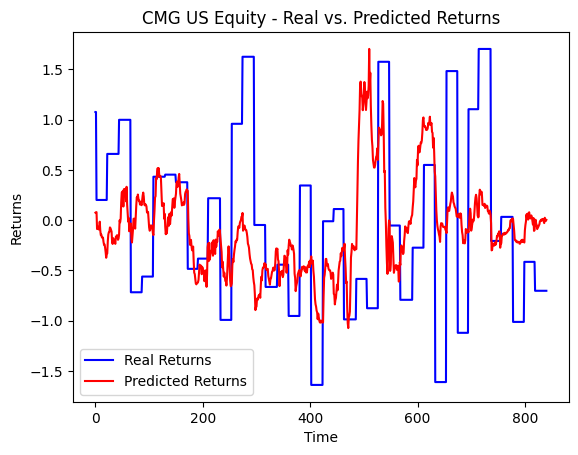

y vs y_pred: (631,) vs (631, 1)


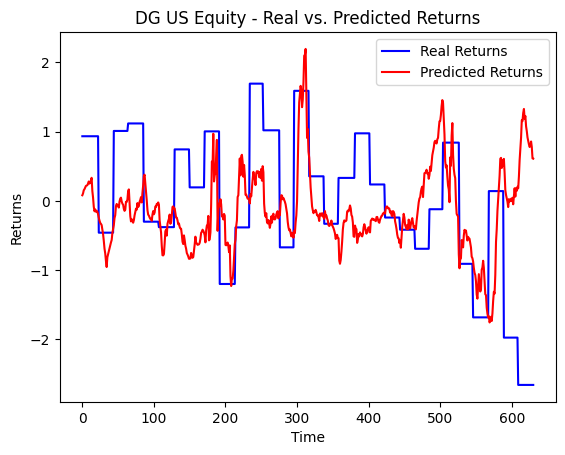

y vs y_pred: (1133,) vs (1133, 1)


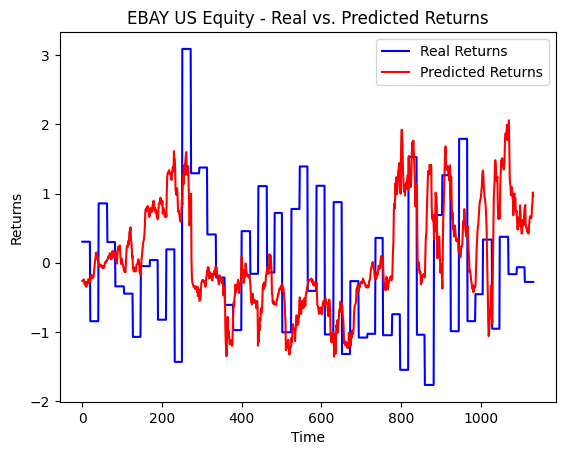

y vs y_pred: (1133,) vs (1133, 1)


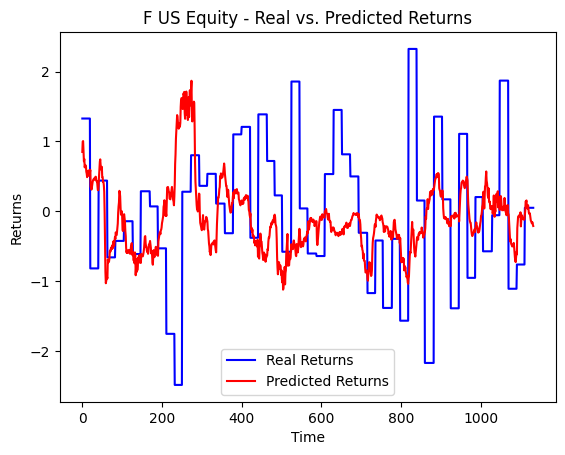

y vs y_pred: (590,) vs (590, 1)


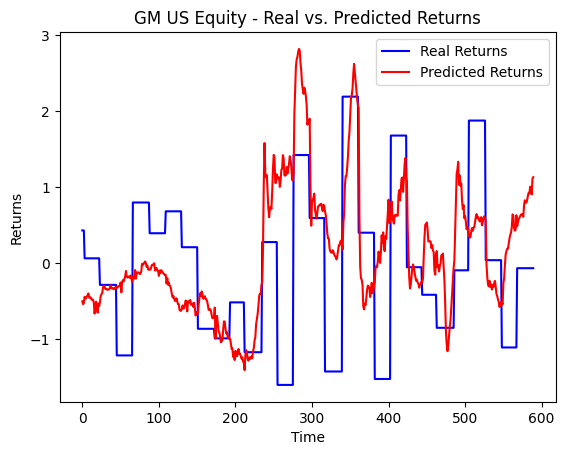

y vs y_pred: (1133,) vs (1133, 1)


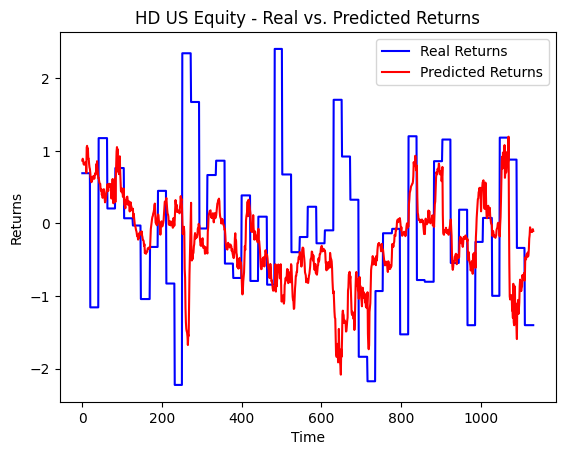

y vs y_pred: (442,) vs (442, 1)


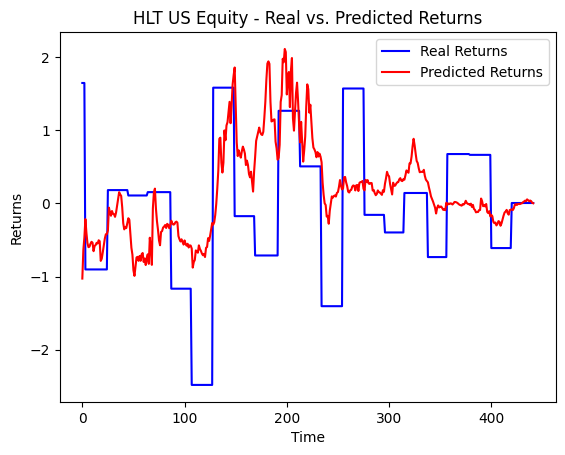

y vs y_pred: (1133,) vs (1133, 1)


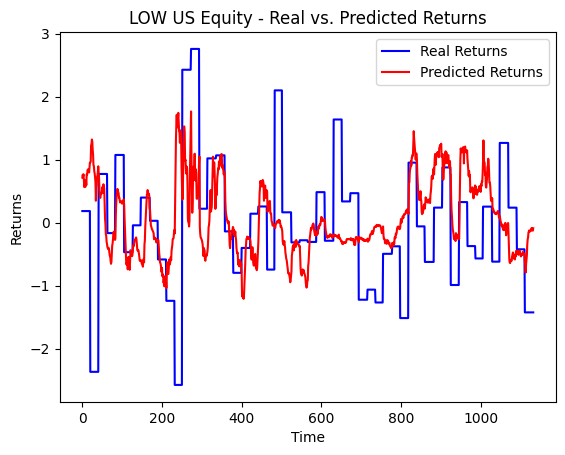

y vs y_pred: (883,) vs (883, 1)


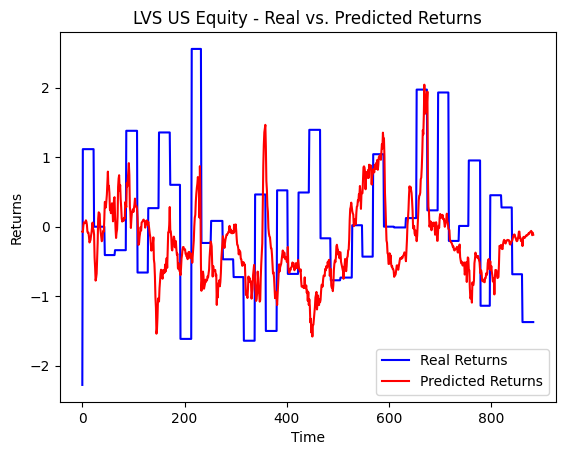

y vs y_pred: (1133,) vs (1133, 1)


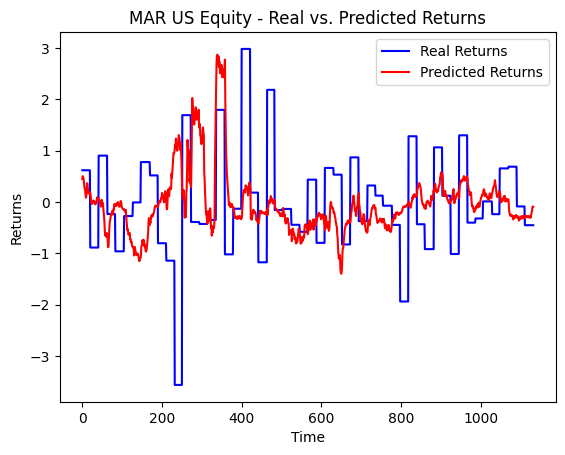

y vs y_pred: (1133,) vs (1133, 1)


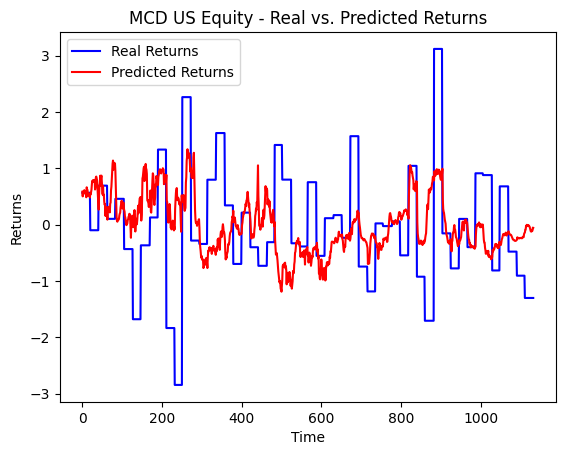

y vs y_pred: (1133,) vs (1133, 1)


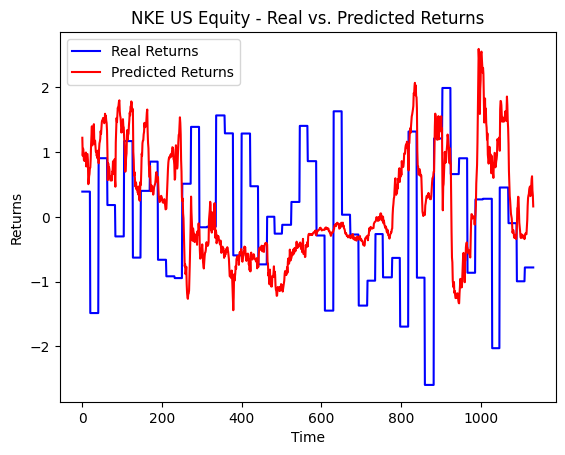

y vs y_pred: (1133,) vs (1133, 1)


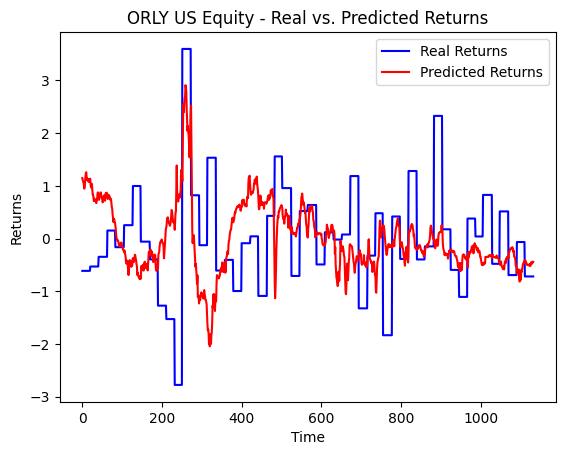

y vs y_pred: (1133,) vs (1133, 1)


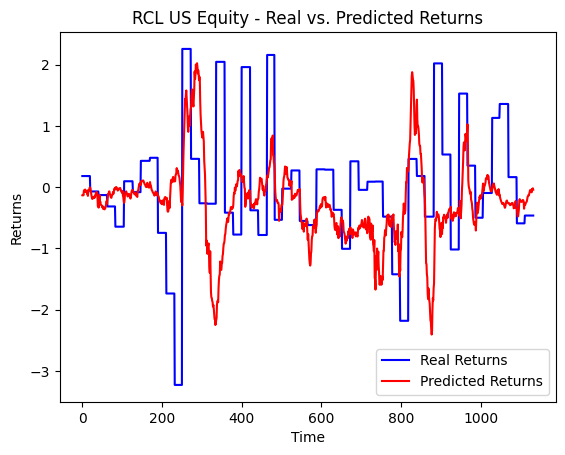

y vs y_pred: (1133,) vs (1133, 1)


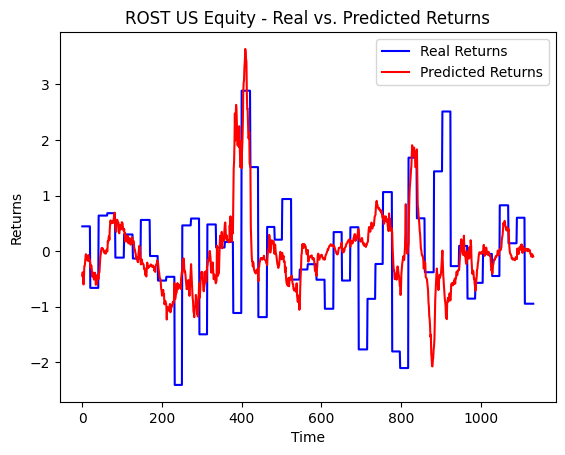

y vs y_pred: (1133,) vs (1133, 1)


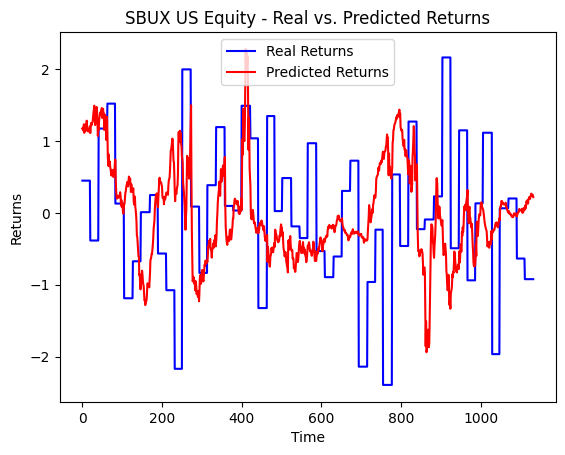

y vs y_pred: (1133,) vs (1133, 1)


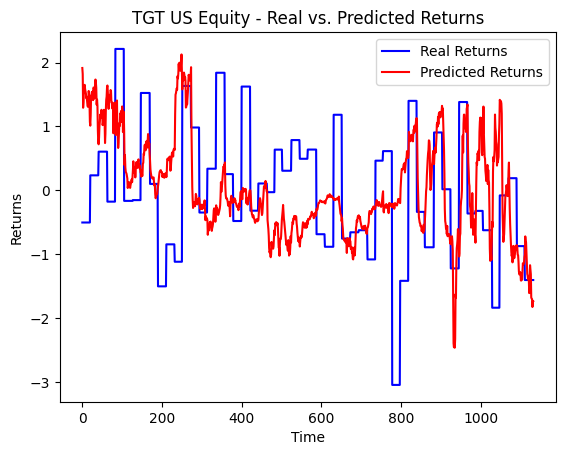

y vs y_pred: (1133,) vs (1133, 1)


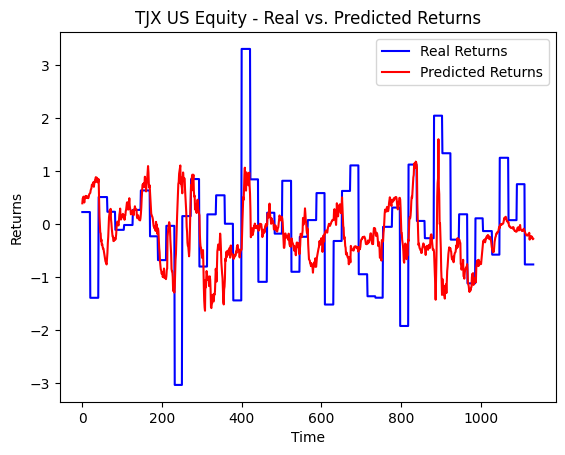

y vs y_pred: (1133,) vs (1133, 1)


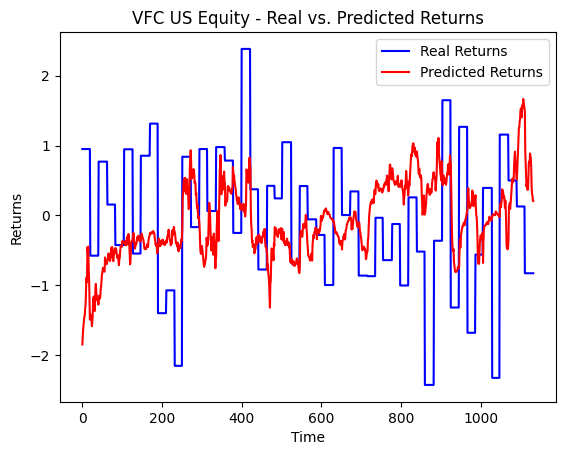

y vs y_pred: (1134,) vs (1134, 1)


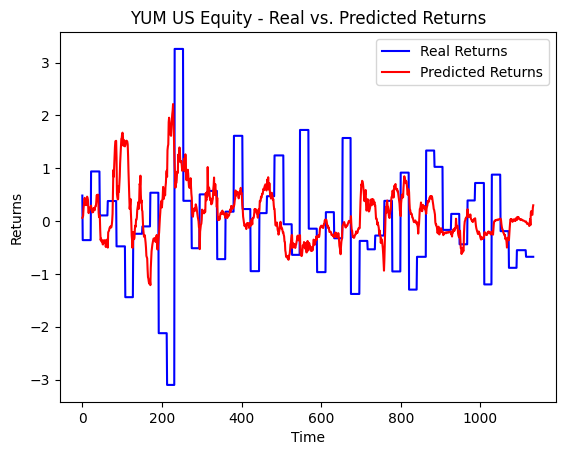

In [ ]:
pred25_aggregate_next  = analyze(pred25_aggregate_next, TASK, mode)


In [ ]:
pred25_aggregate_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.389609   
rmse                                                         1.196923   
mse                                                          1.432625   
y_preds             [[-0.24332373], [-0.2102807], [-0.001548009], ...   
y                   [0.5367546248079017, 0.5367546248079017, 0.536...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            0.07391   
rmse                                                         0.999693   
mse                                                          0.999386   
y_preds             [[-0.34185272], [-0.4789465], [-0.45340928], [...   
y                   [0.5849567495341802, 0.5849567495341802, 0.584...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.118188   
rmse                                                         1.062232   
mse                                                          1.128337   
y_preds             [[0.52859956], [0.49801242], [0.49952197], [0....   
y                   [-0.25638270305473004, -0.25638270305473004, -...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.116528   
rmse                                                         1.073887   
mse                                                          1.153234   
y_preds             [[-0.20042379], [-0.19434735], [-0.258671], [-...   
y                   [0.48942929069276814, 0.48942929069276814, 0.4...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.265854   
rmse                                                         1.144436   
mse                                                          1.309734   
y_preds             [[-1.5335991], [-1.2876935], [-1.2594749], [-1...   
y                   [0.4145305866984984, 0.4145305866984984, 0.414...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.042697   
rmse                                                         0.886154   
mse                                                          0.785269   
y_preds             [[0.07470234], [0.078764796], [0.07986146], [-...   
y                   [1.0767576090255748, 1.0767576090255748, 0.200...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.192727   
rmse                                                         1.114914   
mse                                                          1.243033   
y_preds             [[0.079829305], [0.10578266], [0.1523802], [0....   
y                   [0.9324965125999684, 0.9324965125999684, 0.932...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.497041   
rmse                                                         1.210345   
mse                                                          1.464935   
y_preds             [[-0.26323324], [-0.25734785], [-0.2579338], [...   
y                   [0.3036816543

In [ ]:
save_predictions(pred25_aggregate_next, signature = 'LSTM_pricecf_2000/next/agg', note = 'shallow_epoch2')